In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import lightgbm as lgb
import matplotlib.pyplot as plt
import itertools
import gc

from sklearn import metrics
from datetime import datetime
from pandas_profiling import ProfileReport
from pandas.core.common import SettingWithCopyWarning
from tqdm import tqdm

from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import *

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

RANDOM_STATE = 42
PROJ_PATH = "/home/kirill/projects/personal_projects/xeek-Steam-Optimization/"

train_data_path = PROJ_PATH + "data/raw/train.csv"
test_data_path = PROJ_PATH + "data/raw/test_data.csv"

# Important functions 

In [40]:
def remove_bad_variables(df):
    """Checks dataframe for variables and drops 
    them if present.
    
    df: dataframe
    """
    col_names = list(df.columns)
    for i in ['RMNG_OIL_H', 'GAS_H']:
        if i in col_names:
            df = df.drop(i, axis=1)
    return df


def get_norm_feature_by_group(df, group=['CMPL_FAC_ID'], feature='TOTAL_INJ', res_feature_name='total_inj_fac', fillna=0):

    index, values = [], []
    for mini_df in df.groupby(by=group):
        mini_df = mini_df[1].reset_index()
        max_toinj = mini_df[feature].max()
        
        mini_df[feature] = mini_df[feature] / max_toinj
        mini_df[feature] = mini_df[feature].replace(np.nan, fillna)
        #print(mini_df)
            
        index += mini_df['index'].to_list()
        values += mini_df[feature].to_list()
        
    #print(values)
    df.loc[index, res_feature_name] = values  
    df[res_feature_name] = df[res_feature_name].astype(float)
    return df

def sand_group_num_encoding(sand_id):
    if 'B' in sand_id:
        group = 1
    elif 'D' in sand_id:
        group = 2
    elif 'C' in sand_id:
        group = 3
    else:
        group = 4
    num = sand_id[-1]
    
    return int(group), int(num)


def get_sand_group_mapping(df):
    gr_map = df.groupby(by='CMPL_FAC_ID')['SAND_group'].nunique().tolist()
    gr_map = dict(zip(df['CMPL_FAC_ID'].unique().tolist(), gr_map))

    return gr_map

def get_sinjectors_num(r):
    st_v, st_d = [], []
    st_v.append(r['SGMT_CUM_STM_INJ_1']); st_d.append(r['FT_DIST_PAT_1'])
    st_v.append(r['SGMT_CUM_STM_INJ_2']); st_d.append(r['FT_DIST_PAT_2'])
    st_v.append(r['SGMT_CUM_STM_INJ_3']); st_d.append(r['FT_DIST_PAT_3'])
    
    inj_num = 0
    for i in range(3):
        # all features of one steam inj is not nan
        if not (pd.isna(st_v[i]) or pd.isna(st_d[i])):
            inj_num += 1
            
    return inj_num

def move_sinjectors_columns(df):
    df = df.copy()
    steam_inj_cols = [[f'SGMT_CUM_STM_INJ_{i+1}', f'FT_DIST_PAT_{i+1}'] for i in range(3)]
    for i, r in tqdm(df.iterrows()):
        # get all not nan SGMT_CUM_STM_INJ and FT_DIST_PAT features
        st_v, st_d = [], []
        for st_i in steam_inj_cols:
            # all features of one steam inj is not nan
            if not (pd.isna(r[st_i[0]]) or pd.isna(r[st_i[1]])):
                st_v.append(r[st_i[0]])
                st_d.append(r[st_i[1]])
                    
        # fill empty nan values
        nan_num = 3 - len(st_v)
        st_v = st_v + [np.nan] * nan_num
        st_d = st_d + [np.nan] * nan_num

        df.loc[i, [sg[0] for sg in steam_inj_cols]] = st_v#steam_inj_features
        df.loc[i, [sg[1] for sg in steam_inj_cols]] = st_d                    
    return df


def get_surv_dte(s):
    if '/' in s:
        return datetime.strptime(s, '%m/%d/%Y')
    else:
        return datetime.strptime(s, '%Y-%m-%d')
    

# relationship between normalzied seq_num and target
def get_seq_num(df, res_feature_name='seq_num', normalize=True):
    df = df.copy()
    df = df.sort_values(by='SURV_DTE')
    
    group = df.groupby(by=['CMPL_FAC_ID', 'SAND'])
    group_camcount =  group.cumcount()
    df[res_feature_name] = df.index.map(group_camcount)
    
    if normalize:
        sand_count_mapping = dict()
        for i in df['CMPL_FAC_ID'].unique():
            _df = df[df['CMPL_FAC_ID'] == i]
            sand_count_mapping[i] = _df.groupby(by='SAND')[res_feature_name].max().to_dict()
        df[res_feature_name] = df[res_feature_name] / df.apply(lambda x: sand_count_mapping[x['CMPL_FAC_ID']][x['SAND']], axis=1)
        df[res_feature_name] = df[res_feature_name].fillna(0)
        
    df[res_feature_name] = df[res_feature_name].astype(float)
    df = df.sort_index() 
    return df
    
    
def get_life_time(df, group=['CMPL_FAC_ID'], res_feature_name='fcl_life_time', normalize=True):
    df = df.copy()
    df[res_feature_name] = df['SURV_DTE']
    
    index, values = [], []
    for mini_df in df.groupby(by=group):
        mini_df = mini_df[1].reset_index()
        min_lifetime = mini_df[res_feature_name].min()
        mini_df[res_feature_name] = mini_df[res_feature_name].map(lambda x: (x - min_lifetime).days)
        mini_df[res_feature_name] = mini_df[res_feature_name].replace(0, 1)

        if normalize:
            mini_df[res_feature_name] = (mini_df[res_feature_name]) / mini_df[res_feature_name].max()
            
        index += mini_df['index'].to_list()
        values += mini_df[res_feature_name].to_list()
        
    #print(values)
    df.loc[index, res_feature_name] = values  
    df[res_feature_name] = df[res_feature_name].astype(float)
    return df


def get_first_fcl_month(df, res_feature_name='first_fcl_month'):
    df = df.copy()
    df[res_feature_name] = df['SURV_DTE']
    
    fm_mapping = df.groupby(by='CMPL_FAC_ID')[res_feature_name].min().map(lambda x: x.month)
    df[res_feature_name] = df['CMPL_FAC_ID'].map(fm_mapping)
    df[res_feature_name] = df[res_feature_name].astype(float)
    return df


def get_sand_num_mapping(df):
    sand_num_map = dict()
    for i in list(df['CMPL_FAC_ID'].unique()):
        sand_num_map[i] = len(df[df['CMPL_FAC_ID'] == i]['SAND'].unique())

    return sand_num_map

# for dip, orig_oil_sat, orig_oil_h
def get_mean_std_feature(df, feature):
    df_dupl = df.drop_duplicates(subset=['CMPL_FAC_ID', 'SAND'])
    _mean = df_dupl.groupby(by='CMPL_FAC_ID')[feature].mean()
    _std = df_dupl.groupby(by='CMPL_FAC_ID')[feature].std()
    
    del df_dupl
    gc.collect()
    _mean, _std = _mean.to_dict(), _std.to_dict()
    return _mean, _std

# for camulative features, for TOTAL_GNTL_INJ, Lin_Dist_Inj_Factor, SGMT_CUM_STM_INJ_[1/2/3]
# and Lin_Dist_Prod_Factor
def get_mean_std_by_last_date_feature(df, feature):
    feature_mapping_mean, feature_mapping_std = dict(), dict()
    for i in df['CMPL_FAC_ID'].unique():
        _df = df[df['CMPL_FAC_ID'] == i]
        _df['SURV_DTE'] = pd.to_datetime(_df['SURV_DTE'])
        sands_last_values = _df.sort_values(by='SURV_DTE', ascending=False).groupby(by='SAND')[feature].first()
        
        _mean = sands_last_values.mean()
        _std = sands_last_values.std()
        
        feature_mapping_mean[i] = _mean
        feature_mapping_std[i] = _std
        
    return feature_mapping_mean, feature_mapping_std


def get_target_group(t):
    if t == 0:
        return 1
    if 0 < t < 1:
        return 2
    else:
        return 3
    
def get_mean_osat(df, sgroup_col='sand_group', new_feature_name='mean_group_orig_sat'):
    gr = df.groupby(by=['CMPL_FAC_ID', sgroup_col])['AVG_ORIG_OIL_SAT'].mean()
    gr = gr.unstack(level=1)
    f = lambda x: gr.loc[x['CMPL_FAC_ID'], x[sgroup_col]]
    df[new_feature_name] = df.apply(f, axis=1)
    
    return df

# Info about features

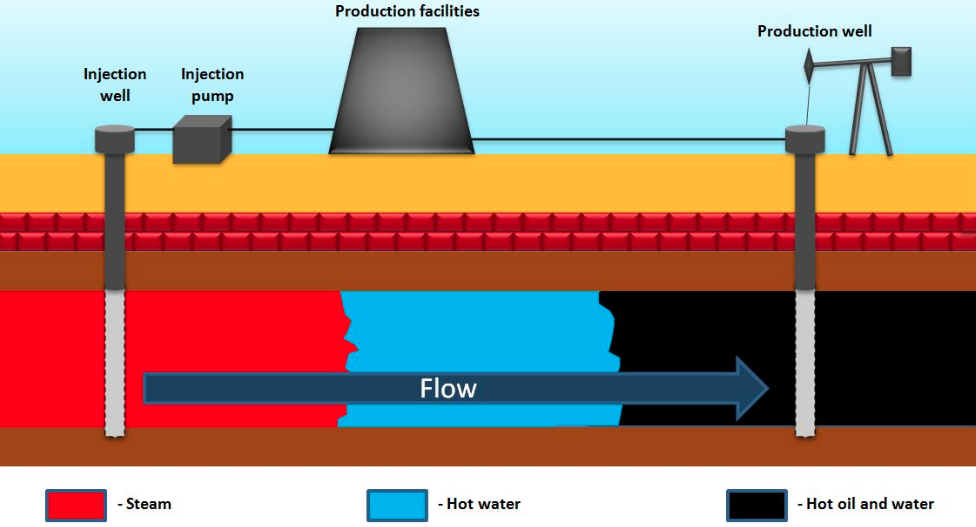

В чем смысл, в некоторых слоях песка есть очень вязкая нефть и добывать ее через production well - сложно, как решают проблему:
1. С помощью injection well нагоняют водяной пар в нефтенесущие слои(в данных это SAND/Reservoir)
2. Нефть разбавляется и становится менее вязкой(десатурация)
3. Теперь нефть проще добыть через production well

Но задача пропуска пара очень затратная, ребята хотят оптимизировать этот процесс. Таск на предикт "сатурированности" нефти по отношению к ее исходной вязкости, для предикта используем след. фичи:


* PCT_DESAT_TO_ORIG - target, descrease in oil saturation(снижение нефтенасыщености)
* CMPL_FAC_ID - well indifier(айдишник скважины)
* SAND - layer indifier(айдшник слоя песка в котором добываем нефть)
* SURV_DTE - date of measurements
* DIP - dip of SAND's/Reservoir's, падение это угол между горизонтом и началом породы, чем больше этот угол тем "круче" расположены границы слоя если смотреть сверху на породу, а reservoir это пласт из многих видов песка с одинаковыми свойствами
* AVG_ORIG_OIL_SAT - started average oil saturation, средний показатель сатурации нефти при старте добычи
* ORIG_OIL_H - started oil column height, высота нефтяного слоя так это выглядит - https://www.researchgate.net/profile/Rahim-Masoudi/publication/266477496/figure/fig14/AS:668299662737421@1536346464474/Types-of-thin-oil-column-reservoirs-a-Pancake-shape-thin-oil-column-b-Rim-shape-thin.png
* SGMT_CUM_STM_INJ_[1/2/3] - total amount of steam which has been injected, общее количество(? неизв. мера) водяного пора, которое было закачано в нефтяные пласты
* FT_DIST_PAT_[1/2/3] - distance between production weel and steam injection weel, расстояние в футах между скважиной и податчиком водяного пара
* TOTAL_PROD - total amount of getted oil, общее кол-во нефти полученое на данный момент времени
* TOTAL_INJ - total amount of injected steam in reservoir, сколько пара закачали в нефтедобывающую породу
* TOTAL_GNTL_INJ - total amount of injected in SAND, сколько пара закачали в определенный слой песка
* Lin_Dist_Inj_Factor - ?! хз, вероятно коэф "сложности" доставки пара !
* Lin_Dist_Prod_Factor - ?! хз, вероятно коэф "сложности" извлечения нефти !

In [142]:
df_train = remove_bad_variables(pd.read_csv(train_data_path))
df_test = pd.read_csv(test_data_path)

In [289]:
df_train

CMPL_FAC_ID     SAND    SURV_DTE   DIP  AVG_ORIG_OIL_SAT  ORIG_OIL_H  \
0             435  TULS_D1  10/25/2012  0.05              0.70       21.06   
1             435  TULS_D1    9/2/2016  0.05              0.70       21.06   
2             435  TULS_D2    1/1/1990  0.06              0.70       14.58   
3             435  TULS_D2  10/25/2012  0.06              0.70       14.58   
4             435  TULS_D2    9/2/2016  0.06              0.70       14.58   
...           ...      ...         ...   ...               ...         ...   
7999      1009291  TULS_D1   3/29/2020  0.07              0.21       11.00   
8000      1009291  TULS_D2    1/1/1990  0.07              0.19        9.50   
8001      1009291  TULS_D2   3/29/2020  0.07              0.19        9.50   
8002      1009291  TULS_D4   3/29/2020  0.07              0.21        6.41   
8003      1009291  TULS_E5   3/29/2020  0.09              0.20       22.00   

         TOTAL_INJ  TOTAL_GNTL_INJ  Lin_Dist_Inj_Factor  SGMT_CUM_STM_INJ_1  \
0     1.246190e+08         3164720                0.269                 NaN   
1     1.791845e+08         4085829                0.302                 NaN   
2     0.000000e+00               0                0.218                 0.0   
3     1.246190e+08          511013                0.218                 NaN   
4     1.791845e+08          880407                0.229                 NaN   
...            ...             ...                  ...                 ...   
7999  2.351197e+08         2786043                0.504            337133.0   
8000  0.000000e+00               0                0.523                 0.0   
8001  2.351197e+08         2298752                0.523            498418.0   
8002  2.351197e+08          263145                0.221                 0.0   
8003  2.351197e+08          994188                0.328            189800.0   

      FT_DIST_PAT_1  SGMT_CUM_STM_INJ_2  FT_DIST_PAT_2  SGMT_CUM_STM_INJ_3  \
0               NaN            551231.0          372.0            942465.0   
1               NaN            963379.0          372.0            994686.0   
2               NaN                 0.0            NaN                 0.0   
3               NaN                 NaN            NaN            232391.0   
4               NaN                 NaN            NaN            416613.0   
...             ...                 ...            ...                 ...   
7999          247.0            684455.0          254.0            596136.0   
8000          247.0                 0.0          254.0                 0.0   
8001          247.0            503853.0          254.0            439492.0   
8002          247.0                 NaN            NaN            272619.0   
8003          247.0                 NaN            NaN                 NaN   

      FT_DIST_PAT_3  TOTAL_PROD  Lin_Dist_Prod_Factor  PCT_DESAT_TO_ORIG  
0             465.0     8904160              0.410639               1.00  
1             465.0    18796208              0.380935               1.00  
2             465.0           0              0.410639               0.00  
3             465.0     8904160              0.410639               0.79  
4             465.0    18796208              0.380935               1.00  
...             ...         ...                   ...                ...  
7999          459.0    14844194              0.288314               0.00  
8000          459.0           0              0.288314               0.00  
8001          459.0    14844194              0.288314               0.00  
8002          459.0    14844194              0.288314               0.84  
8003            NaN    14844194              0.288314               0.02  

[8004 rows x 18 columns]

In [185]:
profile = ProfileReport(df_train, title='Pandas Profiling Report', explorative=True)

In [ ]:
profile

<AxesSubplot:>

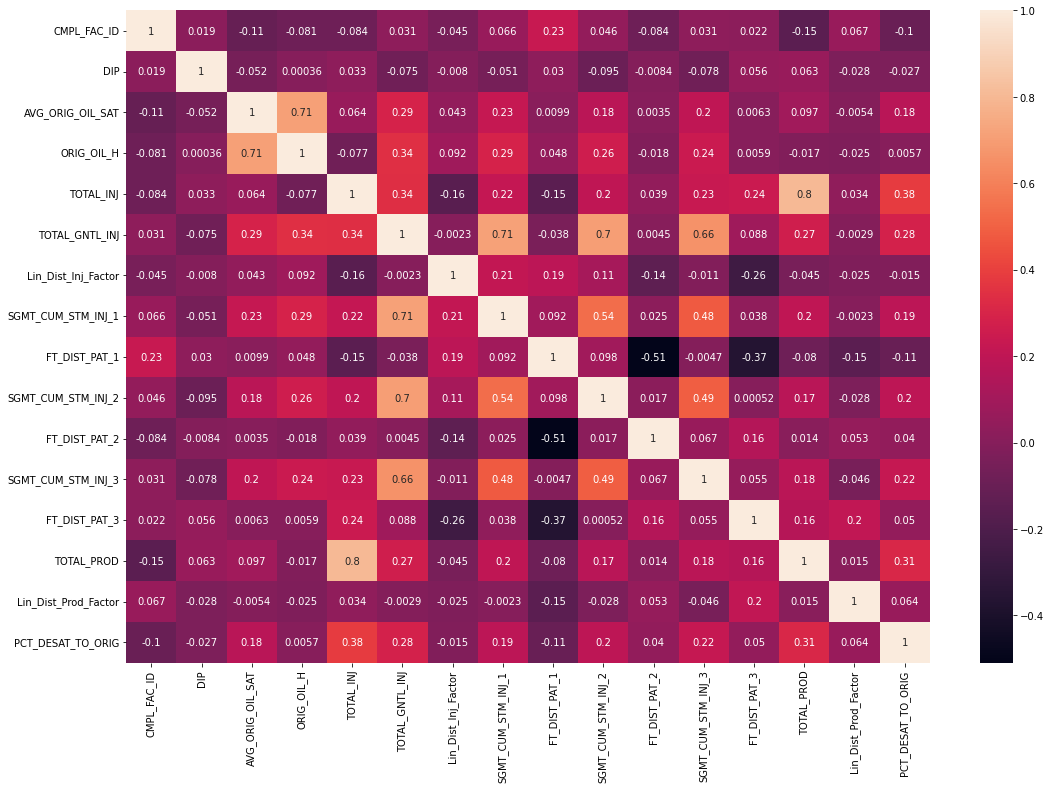

In [150]:
%matplotlib inline

_, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(df_train.corr(), annot=True, ax=ax)

/home/kirill/projects/personal_projects/xeek-Steam-Optimization/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PCT_DESAT_TO_ORIG', ylabel='Density'>

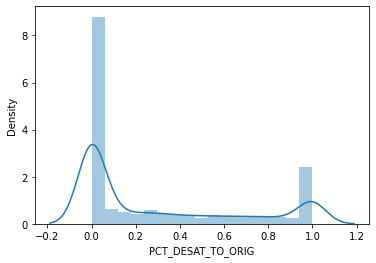

In [92]:
sns.distplot(df_train['PCT_DESAT_TO_ORIG'])

/tmp/ipykernel_8854/1556656297.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.distplot(df_train[df_train['PCT_DESAT_TO_ORIG'] != 0][df_train['PCT_DESAT_TO_ORIG'] != 1]['PCT_DESAT_TO_ORIG'])
/home/kirill/projects/personal_projects/xeek-Steam-Optimization/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PCT_DESAT_TO_ORIG', ylabel='Density'>

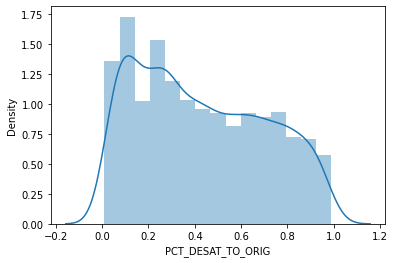

In [99]:
sns.distplot(df_train[df_train['PCT_DESAT_TO_ORIG'] != 0][df_train['PCT_DESAT_TO_ORIG'] != 1]['PCT_DESAT_TO_ORIG'])

In [ ]:
sns.distplot(df_train[df_train['PCT_DESAT_TO_ORIG'] != 0]['PCT_DESAT_TO_ORIG'])

# Total_prod / TOTAL_INJ / TOTAL_GNTL_INJ growth with time?

In [39]:
def plot_camulative_feature(df, pw_id, feature):
    df_pw = df_train[df_train['CMPL_FAC_ID'] == pw_id]
    df_pw['timestamp'] = pd.to_datetime(df_pw['SURV_DTE'])
    df_pw = df_pw.sort_values(by='timestamp')
    df_pw.reset_index(drop=True, inplace=True)
    
    sns.lineplot(y=df_pw[feature], x=range(len(df_pw)))
    plt.show()

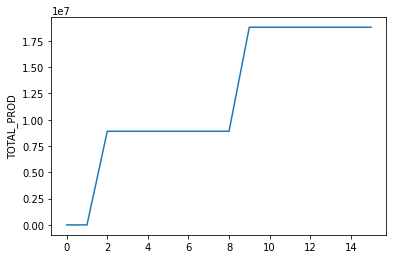

In [42]:
%matplotlib inline

plot_camulative_feature(df_train, 435, 'TOTAL_PROD')

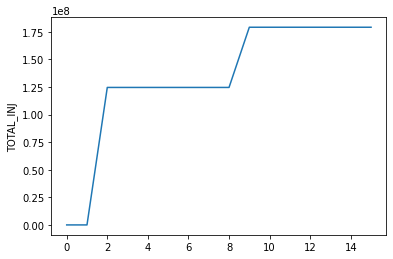

In [43]:
%matplotlib inline

plot_camulative_feature(df_train, 435, 'TOTAL_INJ')

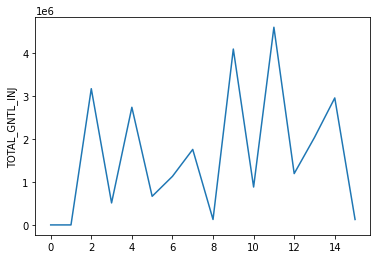

In [44]:
%matplotlib inline

plot_camulative_feature(df_train, 435, 'TOTAL_GNTL_INJ')

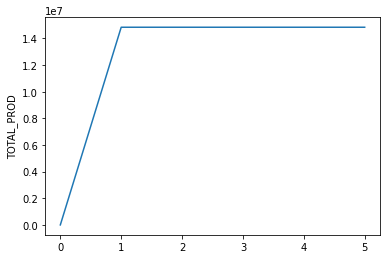

In [48]:
%matplotlib inline

plot_camulative_feature(df_train, 1009291, 'TOTAL_PROD')

# New feature: steam injectors num

Move FT_DIST_PAT / SGMT_CUM_STM_INJ columns by number of steam injectors

<AxesSubplot:ylabel='Frequency'>

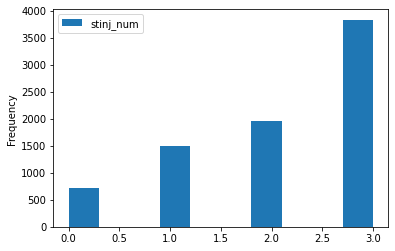

In [23]:
%matplotlib inline

# number of steam injectors
df_train.plot(y='stinj_num', kind='hist')

In [28]:
# steam unjectors num and mean target

print(df_train[df_train['stinj_num'] == 0]['PCT_DESAT_TO_ORIG'].mean())
print(df_train[df_train['stinj_num'] == 1]['PCT_DESAT_TO_ORIG'].mean())
print(df_train[df_train['stinj_num'] == 2]['PCT_DESAT_TO_ORIG'].mean())
print(df_train[df_train['stinj_num'] == 3]['PCT_DESAT_TO_ORIG'].mean())

0.19675034867503485
0.19910487641950572
0.248734693877551
0.3700313315926893


# New features: Generate time features
* plifetime_fcl
;life time of facility in %, 0% - first measurement
* plifetime_sand_fcl 
;life time of sand in facility in %
* lifetime_fcl 
;life time if facility in weeks
* lifetime_sand_fcl
;life time of sand in facility in weeks
* fcl_sand_seq_num
;Number of measurement in context of facility sand
* first_life_month
;Normalized number of month when start produced oil, in context facility sand

In [37]:
RANDOM_STATE = 42

PROJ_PATH = "/home/kirill/projects/personal_projects/xeek-Steam-Optimization/"
train_data_path = PROJ_PATH + "data/raw/train.csv"
test_data_path = PROJ_PATH + "data/raw/test_data.csv"
columns = ['CMPL_FAC_ID', 'SAND', 'SURV_DTE', 'PCT_DESAT_TO_ORIG', 'AVG_ORIG_OIL_SAT']

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

In [5]:
df_train[df_train['CMPL_FAC_ID'] == 1009291][columns]

CMPL_FAC_ID     SAND   SURV_DTE  PCT_DESAT_TO_ORIG  AVG_ORIG_OIL_SAT
7998      1009291  TULS_D5  3/29/2020               0.75              0.37
7999      1009291  TULS_D1  3/29/2020               0.00              0.21
8000      1009291  TULS_D2   1/1/1990               0.00              0.19
8001      1009291  TULS_D2  3/29/2020               0.00              0.19
8002      1009291  TULS_D4  3/29/2020               0.84              0.21
8003      1009291  TULS_E5  3/29/2020               0.02              0.20

In [6]:
df_train[df_train['CMPL_FAC_ID'] == 435][columns]

CMPL_FAC_ID     SAND    SURV_DTE  PCT_DESAT_TO_ORIG  AVG_ORIG_OIL_SAT
0           435  TULS_D1  10/25/2012               1.00              0.70
1           435  TULS_D1    9/2/2016               1.00              0.70
2           435  TULS_D2    1/1/1990               0.00              0.70
3           435  TULS_D2  10/25/2012               0.79              0.70
4           435  TULS_D2    9/2/2016               1.00              0.70
5           435  TULS_D3  10/25/2012               0.35              0.50
6           435  TULS_D3    9/2/2016               0.61              0.50
7           435  TULS_E1    1/1/1990               0.00              0.19
8           435  TULS_E1  10/25/2012               0.00              0.19
9           435  TULS_E1    9/2/2016               0.00              0.19
10          435  TULS_E2  10/25/2012               0.00              0.34
11          435  TULS_E2    9/2/2016               0.13              0.34
12          435  TULS_E3  10/25/2012               0.00              0.68
13          435  TULS_E3    9/2/2016               0.00              0.68
14          435  TULS_E4    9/2/2016               0.00              0.11
15          435  TULS_E4  10/25/2012               0.00              0.11

In [126]:
new_df['SURV_DTE'] = df_train['SURV_DTE'].map(get_surv_dte)

new_df = get_seq_num(new_df, normalize=True)
new_df = get_seq_num(new_df, res_feature_name='seq_num_un', normalize=False)
new_df = get_life_time(new_df, normalize=True)
new_df = get_life_time(new_df, res_feature_name='fcl_life_time_un', normalize=False)
new_df = get_life_time(new_df, group=['CMPL_FAC_ID', 'SAND'], res_feature_name='fcl_sand_life_time', normalize=True)
new_df = get_life_time(new_df, group=['CMPL_FAC_ID', 'SAND'], res_feature_name='fcl_sand_life_time_un', normalize=False)
new_df = get_first_fcl_month(new_df, res_feature_name='first_fcl_month')

<AxesSubplot:>

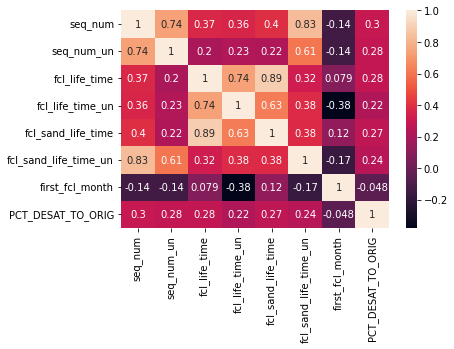

In [129]:
%matplotlib inline

new_features = [
    'seq_num', 'seq_num_un',
    'fcl_life_time', 'fcl_life_time_un',
    'fcl_sand_life_time', 'fcl_sand_life_time_un',
    'first_fcl_month',
    'PCT_DESAT_TO_ORIG'
]

sns.heatmap(new_df[new_features].corr(), annot=True)

In [164]:
df_time_preproc = get_seq_num(df_train, normalize=True)

for s in df_time_preproc['SAND'].unique():
    _df = df_time_preproc[df_time_preproc['SAND'] == s]
    cor = _df[['PCT_DESAT_TO_ORIG', 'seq_num']].corr().iloc[0, 1]
    print(f'SAND - {s}, corr: {cor}')


SAND - TULS_D1, corr: 0.3176153862129659
SAND - TULS_D2, corr: 0.341351924963692
SAND - TULS_D3, corr: 0.3340291514859084
SAND - TULS_E1, corr: 0.3207616489482306
SAND - TULS_E2, corr: 0.3411245979909308
SAND - TULS_E3, corr: 0.2790611543294657
SAND - TULS_E4, corr: 0.24895662552212722
SAND - TULS_E5, corr: 0.07511684910550011
SAND - TULS_B5, corr: 0.3200236850605907
SAND - TULS_C5, corr: 0.3856134016248825
SAND - TULS_D5, corr: 0.3431024754203236
SAND - TULS_B1, corr: 0.40253762554093236
SAND - TULS_C2, corr: 0.30081471024491097
SAND - TULS_C4, corr: 0.22041019145223817
SAND - TULS_D4, corr: 0.3523899989790151
SAND - TULS_B2, corr: 0.2684398111894606
SAND - TULS_B3, corr: 0.41306585955952896
SAND - TULS_C3, corr: 0.1739763816984811
SAND - TULS_C1, corr: 0.19968629991107986
SAND - TULS_B4, corr: 0.2728652847990178


# New feature's: SAND features for facility
* Sand's number 
* Mean/STD by facility, facility+SAND features:
    * DIP
    * AVG_ORIG_OIL_SAT
    * TOTAL_GNTL_INJ
    * ORIG_OIL_H
    * TOTAL_GNTL_INJ(get biggest from one sand)

In [284]:
new_df = df_train.copy()

dip_mean_map, dip_std_map = get_mean_std_feature(new_df, feature='DIP')
new_df['dip_m'] = new_df['CMPL_FAC_ID'].map(dip_mean_map)
new_df['dip_s'] = new_df['CMPL_FAC_ID'].map(dip_std_map)

OIL_SAT_mean_map, OIL_SAT_std_map = get_mean_std_feature(new_df, feature='AVG_ORIG_OIL_SAT')
new_df['OIL_SAT_m'] = new_df['CMPL_FAC_ID'].map(OIL_SAT_mean_map)
new_df['OIL_SAT_s'] = new_df['CMPL_FAC_ID'].map(OIL_SAT_std_map)

ORIG_OIL_mean_map, ORIG_OIL_std_map = get_mean_std_feature(new_df,feature='ORIG_OIL_H')
new_df['ORIG_OIL_m'] = new_df['CMPL_FAC_ID'].map(ORIG_OIL_mean_map)
new_df['ORIG_OIL_s'] = new_df['CMPL_FAC_ID'].map(ORIG_OIL_std_map)

GNTL_INJ_mean_map, GNTL_INJ_std_map = get_mean_std_by_last_date_feature(new_df, 'TOTAL_GNTL_INJ')
new_df['GNTL_INJ_m'] = new_df['CMPL_FAC_ID'].map(GNTL_INJ_mean_map)
new_df['GNTL_INJ_s'] = new_df['CMPL_FAC_ID'].map(GNTL_INJ_std_map)

In [177]:
new_df[new_df['CMPL_FAC_ID'] == 435]

CMPL_FAC_ID     SAND    SURV_DTE   DIP  AVG_ORIG_OIL_SAT  ORIG_OIL_H  \
0           435  TULS_D1  10/25/2012  0.05              0.70       21.06   
1           435  TULS_D1    9/2/2016  0.05              0.70       21.06   
2           435  TULS_D2    1/1/1990  0.06              0.70       14.58   
3           435  TULS_D2  10/25/2012  0.06              0.70       14.58   
4           435  TULS_D2    9/2/2016  0.06              0.70       14.58   
5           435  TULS_D3  10/25/2012  0.08              0.50       34.87   
6           435  TULS_D3    9/2/2016  0.08              0.50       34.87   
7           435  TULS_E1    1/1/1990  0.07              0.19        5.50   
8           435  TULS_E1  10/25/2012  0.07              0.19        5.50   
9           435  TULS_E1    9/2/2016  0.07              0.19        5.50   
10          435  TULS_E2  10/25/2012  0.07              0.34       11.50   
11          435  TULS_E2    9/2/2016  0.07              0.34       11.50   
12          435  TULS_E3  10/25/2012  0.08              0.68       24.50   
13          435  TULS_E3    9/2/2016  0.08              0.68       24.50   
14          435  TULS_E4    9/2/2016  0.08              0.11        5.00   
15          435  TULS_E4  10/25/2012  0.08              0.11        5.00   

    RMNG_OIL_H  GAS_H     TOTAL_INJ  TOTAL_GNTL_INJ  Lin_Dist_Inj_Factor  \
0         0.00  21.06  1.246190e+08         3164720                0.269   
1         0.00  21.06  1.791845e+08         4085829                0.302   
2        14.58   0.00  0.000000e+00               0                0.218   
3         3.00  11.58  1.246190e+08          511013                0.218   
4         0.00  14.58  1.791845e+08          880407                0.229   
5        22.50  12.37  1.246190e+08         2732929                0.311   
6        13.50  21.37  1.791845e+08         4592459                0.355   
7         5.50   0.00  0.000000e+00               0                0.275   
8         5.50   0.00  1.246190e+08          664495                0.275   
9         5.50   0.00  1.791845e+08         1192252                0.307   
10       11.50   0.00  1.246190e+08         1127882                0.326   
11       10.00   1.50  1.791845e+08         2031988                0.362   
12       24.50   0.00  1.246190e+08         1753702                0.332   
13       24.50   0.00  1.791845e+08         2950123                0.381   
14        5.00   0.00  1.791845e+08          126232                0.307   
15        5.00   0.00  1.246190e+08          126232                0.307   

    SGMT_CUM_STM_INJ_1  FT_DIST_PAT_1  SGMT_CUM_STM_INJ_2  FT_DIST_PAT_2  \
0                  NaN            NaN            551231.0          372.0   
1                  NaN            NaN            963379.0          372.0   
2                  0.0            NaN                 0.0            NaN   
3                  NaN            NaN                 NaN            NaN   
4                  NaN            NaN                 NaN            NaN   
5             297002.0          130.0            303999.0          372.0   
6             613515.0          130.0            696977.0          372.0   
7                  0.0          130.0                 0.0          372.0   
8              39624.0          130.0             86907.0          372.0   
9              39663.0          130.0            300859.0          372.0   
10            171160.0          130.0            103131.0          372.0   
11            266548.0          130.0            433783.0          372.0   
12            201502.0          130.0            165513.0          372.0   
13            483088.0          130.0            398915.0          372.0   
14                 NaN            NaN                 NaN            NaN   
15                 NaN            NaN                 NaN            NaN   

    SGMT_CUM_STM_INJ_3  FT_DIST_PAT_3  TOTAL_PROD  Lin_Dist_Prod_Factor  \
0             942465.0          465.0     8904160 

<AxesSubplot:>

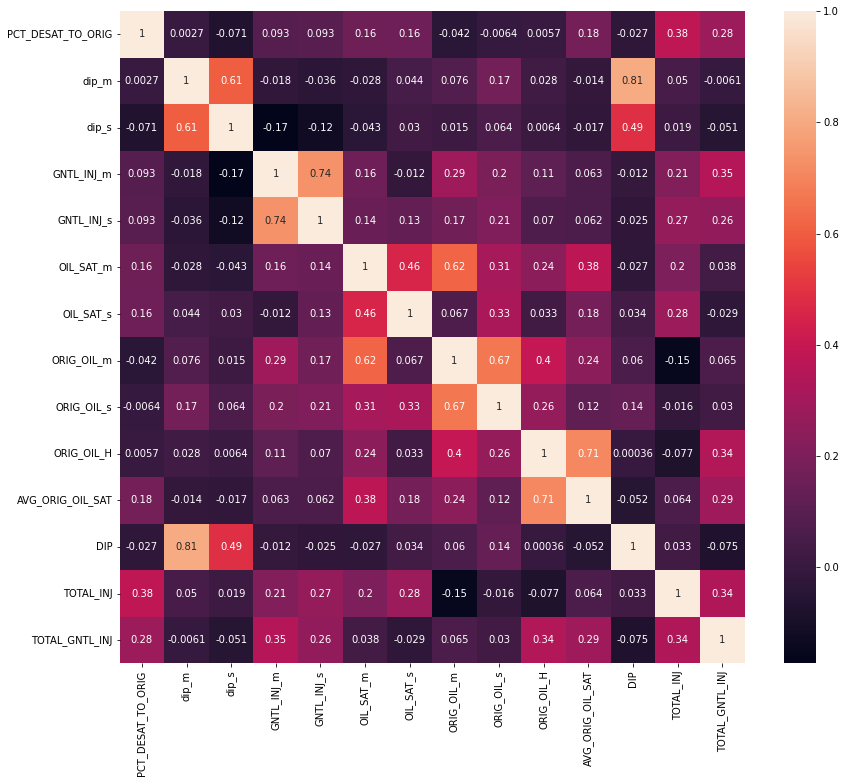

In [285]:
corr = new_df[['PCT_DESAT_TO_ORIG', 'dip_m', 'dip_s', 'GNTL_INJ_m', 'GNTL_INJ_s', 'OIL_SAT_m', 'OIL_SAT_s', 'ORIG_OIL_m', 'ORIG_OIL_s',
       'ORIG_OIL_H', 'AVG_ORIG_OIL_SAT', 'DIP', 'TOTAL_INJ', 'TOTAL_GNTL_INJ']].corr()

_, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr, ax=ax, annot=True)

# SANDS - TARGET relationships

## Rel. between sand group/number and target???

In [274]:
grn = df_train['SAND'].map(sand_group_num_encoding).to_numpy()

df_train['SAND_group'] = [_[0] for _ in grn]
df_train['SAND_num'] = [_[1] for _ in grn]

df_gr_dum = pd.get_dummies(df_train['SAND_group'], prefix='SAND_group')
df_num_dum = pd.get_dummies(df_train['SAND_num'], prefix='SAND_num')

new_df = pd.concat([df_train, df_gr_dum, df_num_dum], axis=1)

# get number of groups
gr_map = get_sand_group_mapping(new_df)
new_df['groups_num'] = new_df['CMPL_FAC_ID'].map(gr_map)

In [236]:
unique_sands = df_train['SAND'].unique()
unique_sands.sort()
print(f'Len un. sands: {len(unique_sands)}')
print(f'Unique sands: {unique_sands}')

Len un. sands: 20
Unique sands: ['TULS_B1' 'TULS_B2' 'TULS_B3' 'TULS_B4' 'TULS_B5' 'TULS_C1' 'TULS_C2'
 'TULS_C3' 'TULS_C4' 'TULS_C5' 'TULS_D1' 'TULS_D2' 'TULS_D3' 'TULS_D4'
 'TULS_D5' 'TULS_E1' 'TULS_E2' 'TULS_E3' 'TULS_E4' 'TULS_E5']


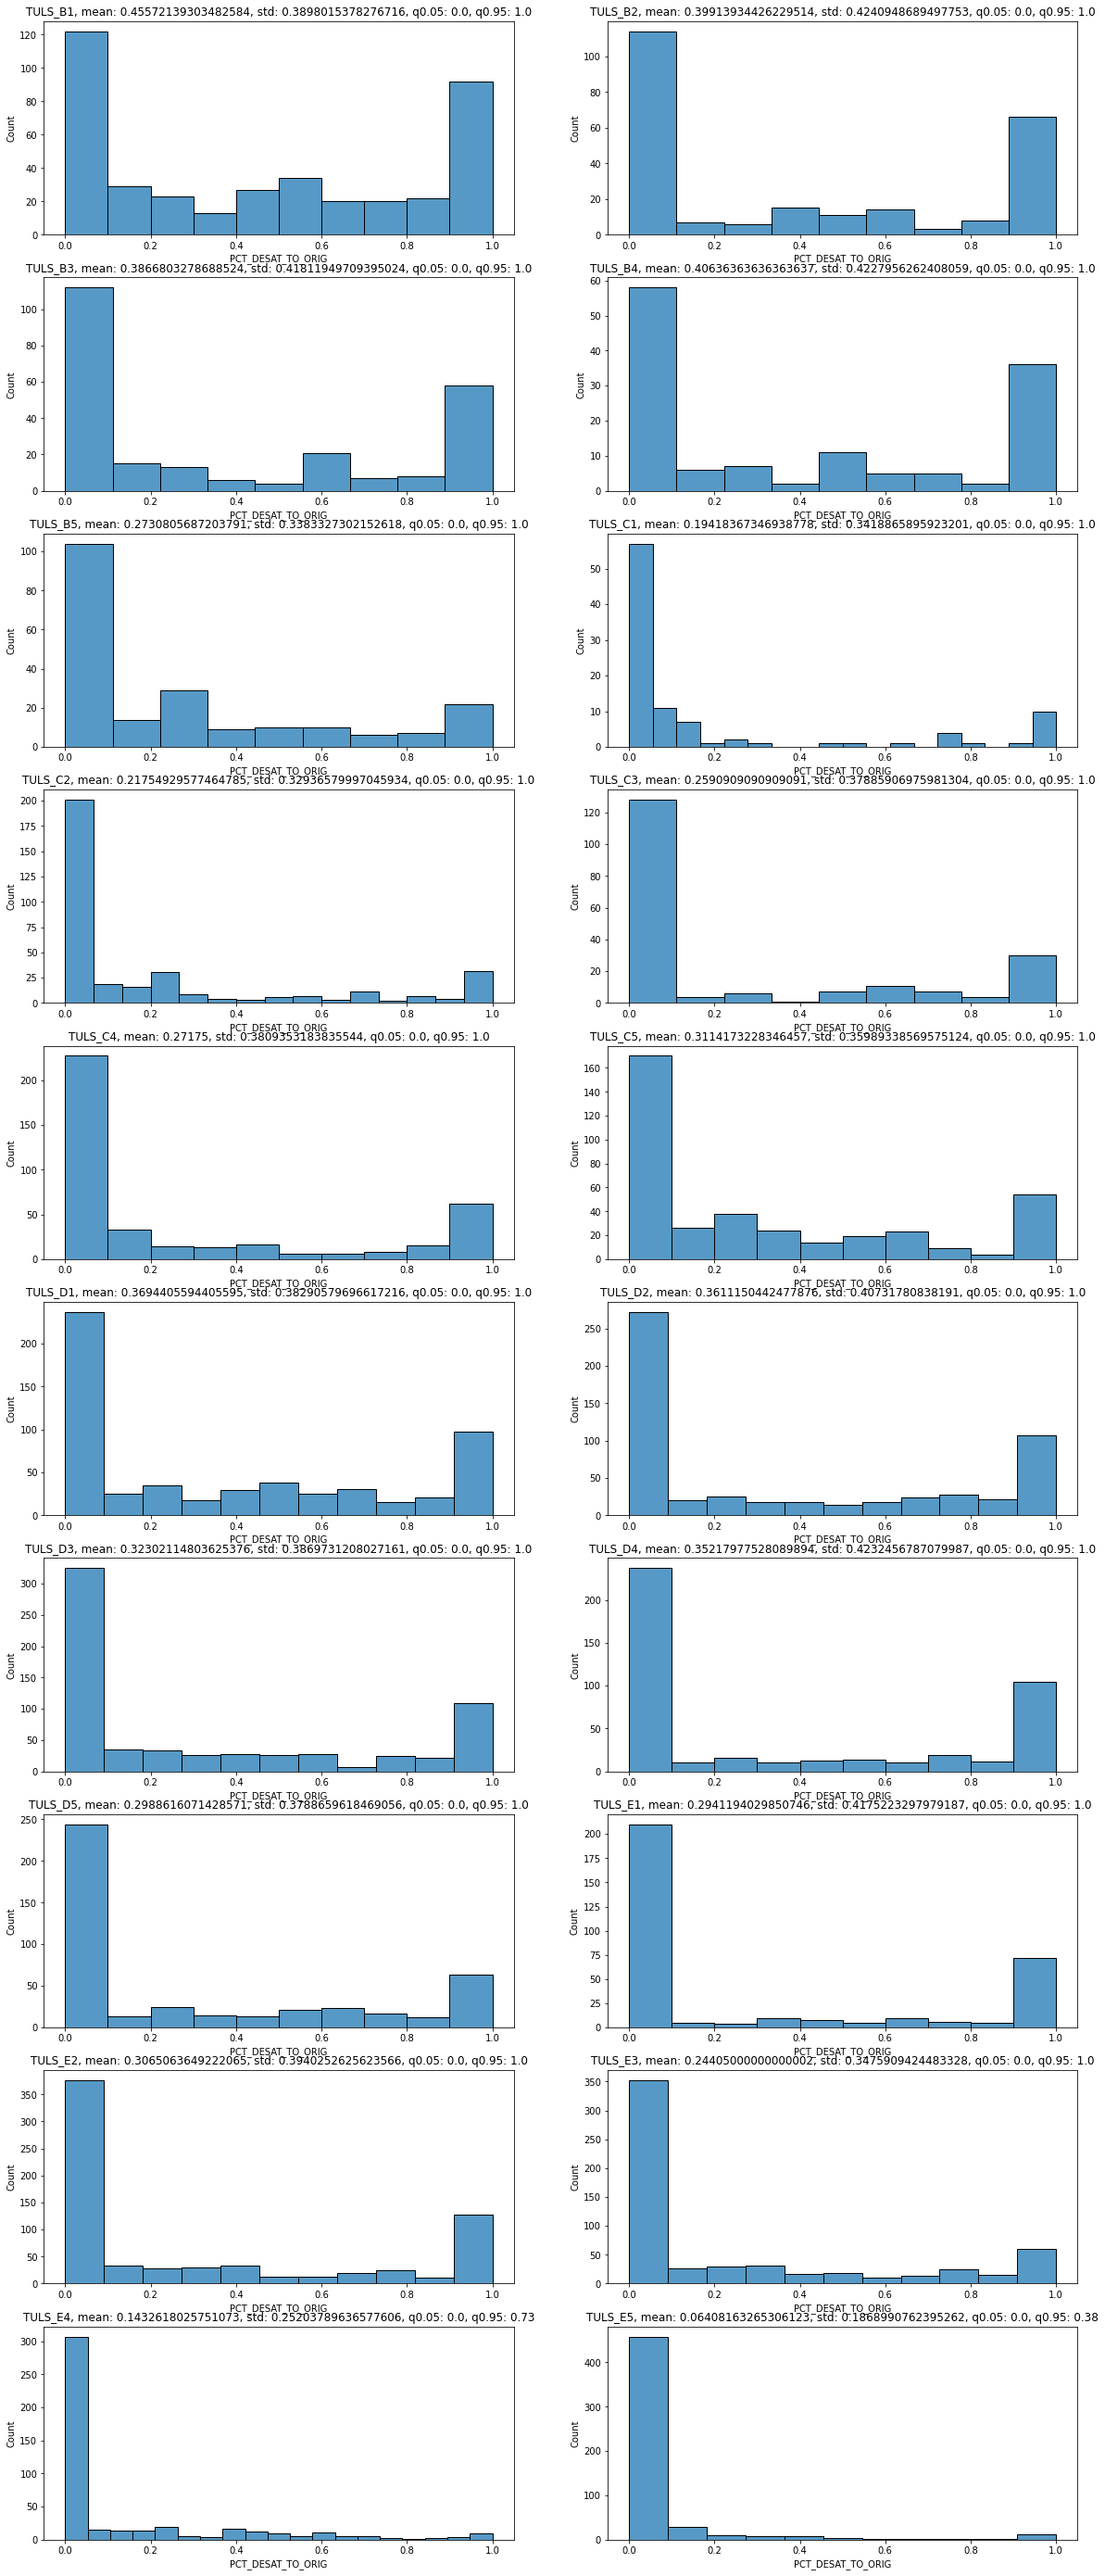

In [237]:
# types of sands


_, ax = plt.subplots(figsize=(20, 10*5), ncols=2, nrows=10)
ax = ax.flatten()

for i, us in enumerate(unique_sands):
    df_sand_train = df_train[df_train['SAND'] == us]  
    target_col = df_sand_train['PCT_DESAT_TO_ORIG']
    sns.histplot(target_col, ax=ax[i])
    info = f'{us}, mean: {target_col.mean()}, std: {target_col.std()}, q0.05: {target_col.quantile(0.05)}, q0.95: {target_col.quantile(0.95)}'
    ax[i].set_title(info)

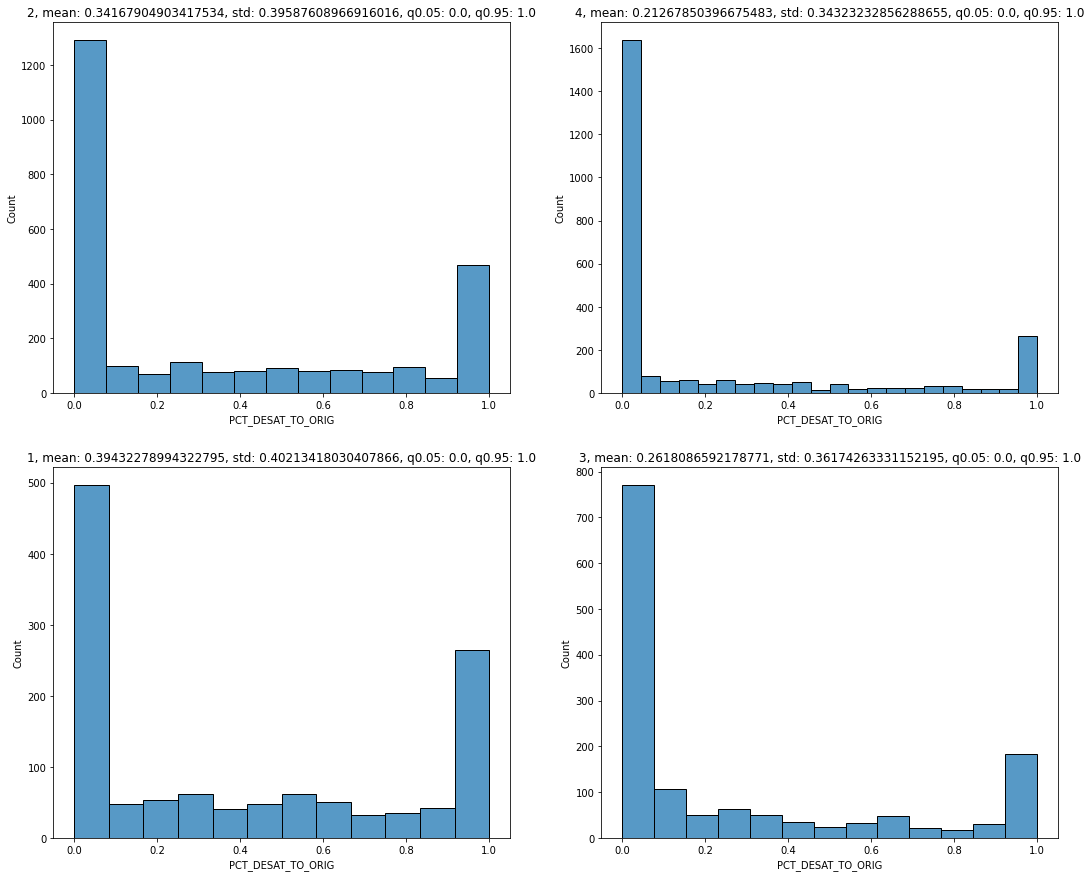

In [240]:
# types of sands groups


_, ax = plt.subplots(figsize=(18, 15), ncols=2, nrows=2)
ax = ax.flatten()

un_sand_group = new_df['SAND_group'].unique()
for i, us in enumerate(un_sand_group):
    df_sandg_train = new_df[new_df['SAND_group'] == us]  
    target_col = df_sandg_train['PCT_DESAT_TO_ORIG']
    sns.histplot(target_col, ax=ax[i])
    info = f'{us}, mean: {target_col.mean()}, std: {target_col.std()}, q0.05: {target_col.quantile(0.05)}, q0.95: {target_col.quantile(0.95)}'
    ax[i].set_title(info)

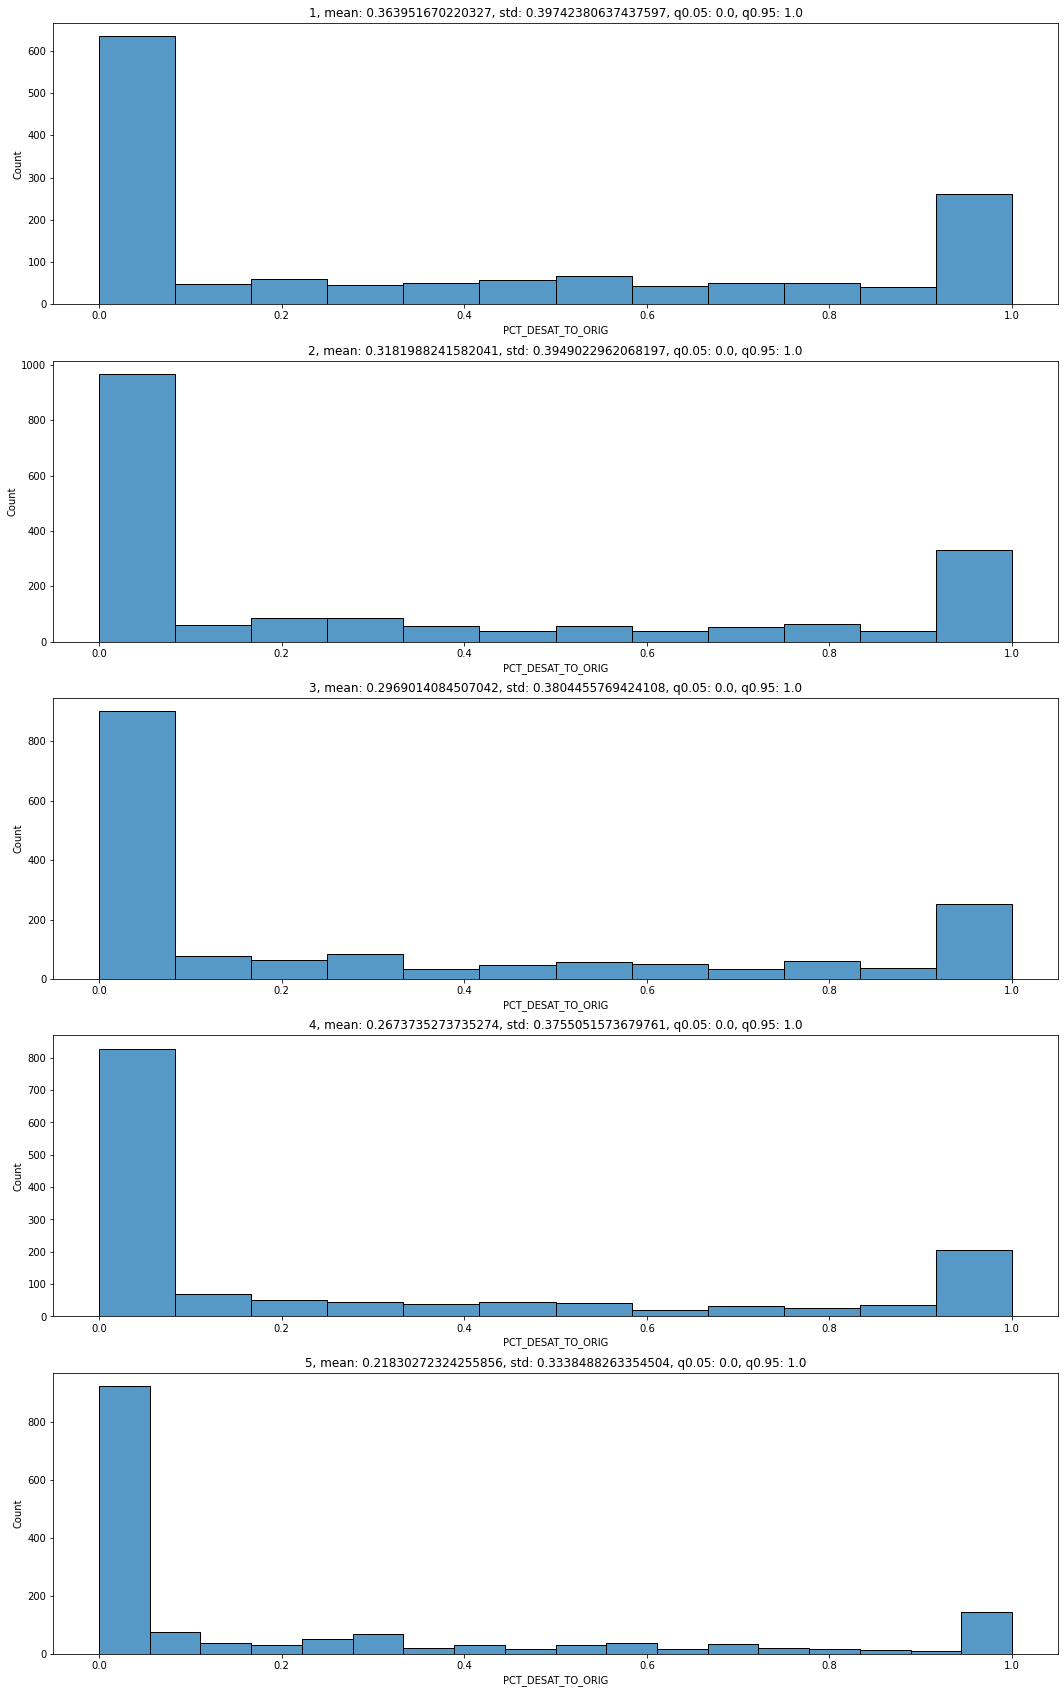

In [243]:
# types of sands nums


_, ax = plt.subplots(figsize=(18, 30), ncols=1, nrows=5)
ax = ax.flatten()

un_sand_num = new_df['SAND_num'].unique()
for i, us in enumerate(un_sand_num):
    df_sandn_train = new_df[new_df['SAND_num'] == us]  
    target_col = df_sandn_train['PCT_DESAT_TO_ORIG']
    sns.histplot(target_col, ax=ax[i])
    info = f'{us}, mean: {target_col.mean()}, std: {target_col.std()}, q0.05: {target_col.quantile(0.05)}, q0.95: {target_col.quantile(0.95)}'
    ax[i].set_title(info)

<AxesSubplot:>

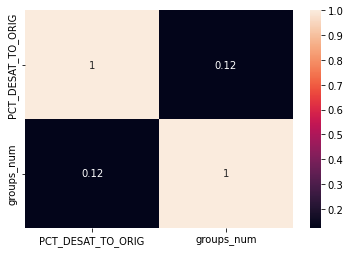

In [280]:
sns.heatmap(new_df[['PCT_DESAT_TO_ORIG', 'groups_num']].corr(), annot=True)

## Average orig saturation in sand groups

<AxesSubplot:>

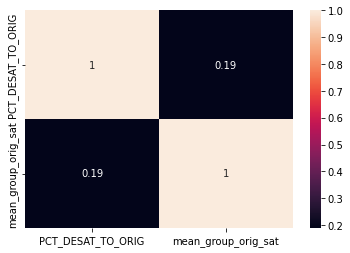

In [145]:
grn = df_train['SAND'].map(sand_group_num_encoding).to_numpy()
prep_df = df_train.copy()
prep_df['sand_group'] = [_[0] for _ in grn]
    
prep_df = get_mean_osat(prep_df, sgroup_col='sand_group')
sns.heatmap(prep_df[['PCT_DESAT_TO_ORIG', 'mean_group_orig_sat']].corr(), annot=True)

## Feature: steam_gntl_inj average my sand group

In [160]:
def get_sinj_by_sand_group(df, sgroup_col='sand_group', new_feature_name='mean_group_sinj_gntl'):
    gr = df.groupby(by=['CMPL_FAC_ID', sgroup_col, 'SURV_DTE'])['TOTAL_GNTL_INJ'].mean()
    
    gr = gr.unstack(level=2)
    
    f = lambda x: gr.loc[x['CMPL_FAC_ID']].loc[x[sgroup_col]].loc[x['SURV_DTE']]
    df[new_feature_name] = df.apply(f, axis=1)
    
    return df

<AxesSubplot:>

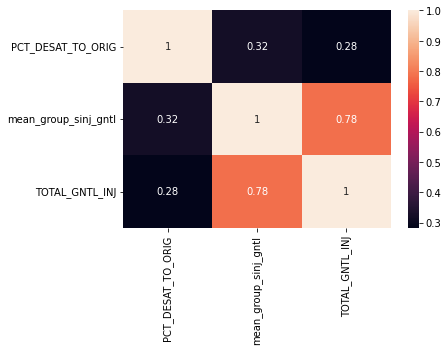

In [166]:
df = get_sinj_by_sand_group(prep_df, sgroup_col='sand_group')
sns.heatmap(prep_df[['PCT_DESAT_TO_ORIG', 'mean_group_sinj_gntl', 'TOTAL_GNTL_INJ']].corr(), annot=True)

## Relationships between majority sand group and desaturation?

In [ ]:

def get_majority_sand_group(df, by):
    fac_mapping = dict()
    for mini_df in df.groupby(by='CMPL_FAC_ID'):
        mini_df = mini_df[1].reset_index()
        max_val = mini_df[by].max()
        maj_sand = mini_df[mini_df[by] == max_val]['SAND']
        
        fac_

In [9]:
df = df_train[['CMPL_FAC_ID', 'SAND', 'SURV_DTE', 'DIP', 'AVG_ORIG_OIL_SAT', 'ORIG_OIL_H', 'RMNG_OIL_H', 'GAS_H', 'TOTAL_INJ', 'TOTAL_GNTL_INJ', 'Lin_Dist_Inj_Factor',
          'TOTAL_PROD', 'Lin_Dist_Prod_Factor', 'PCT_DESAT_TO_ORIG']]

df[df['CMPL_FAC_ID'] == 435]

CMPL_FAC_ID     SAND    SURV_DTE   DIP  AVG_ORIG_OIL_SAT  ORIG_OIL_H  \
0           435  TULS_D1  10/25/2012  0.05              0.70       21.06   
1           435  TULS_D1    9/2/2016  0.05              0.70       21.06   
2           435  TULS_D2    1/1/1990  0.06              0.70       14.58   
3           435  TULS_D2  10/25/2012  0.06              0.70       14.58   
4           435  TULS_D2    9/2/2016  0.06              0.70       14.58   
5           435  TULS_D3  10/25/2012  0.08              0.50       34.87   
6           435  TULS_D3    9/2/2016  0.08              0.50       34.87   
7           435  TULS_E1    1/1/1990  0.07              0.19        5.50   
8           435  TULS_E1  10/25/2012  0.07              0.19        5.50   
9           435  TULS_E1    9/2/2016  0.07              0.19        5.50   
10          435  TULS_E2  10/25/2012  0.07              0.34       11.50   
11          435  TULS_E2    9/2/2016  0.07              0.34       11.50   
12          435  TULS_E3  10/25/2012  0.08              0.68       24.50   
13          435  TULS_E3    9/2/2016  0.08              0.68       24.50   
14          435  TULS_E4    9/2/2016  0.08              0.11        5.00   
15          435  TULS_E4  10/25/2012  0.08              0.11        5.00   

    RMNG_OIL_H  GAS_H     TOTAL_INJ  TOTAL_GNTL_INJ  Lin_Dist_Inj_Factor  \
0         0.00  21.06  1.246190e+08         3164720                0.269   
1         0.00  21.06  1.791845e+08         4085829                0.302   
2        14.58   0.00  0.000000e+00               0                0.218   
3         3.00  11.58  1.246190e+08          511013                0.218   
4         0.00  14.58  1.791845e+08          880407                0.229   
5        22.50  12.37  1.246190e+08         2732929                0.311   
6        13.50  21.37  1.791845e+08         4592459                0.355   
7         5.50   0.00  0.000000e+00               0                0.275   
8         5.50   0.00  1.246190e+08          664495                0.275   
9         5.50   0.00  1.791845e+08         1192252                0.307   
10       11.50   0.00  1.246190e+08         1127882                0.326   
11       10.00   1.50  1.791845e+08         2031988                0.362   
12       24.50   0.00  1.246190e+08         1753702                0.332   
13       24.50   0.00  1.791845e+08         2950123                0.381   
14        5.00   0.00  1.791845e+08          126232                0.307   
15        5.00   0.00  1.246190e+08          126232                0.307   

    TOTAL_PROD  Lin_Dist_Prod_Factor  PCT_DESAT_TO_ORIG  
0      8904160              0.410639               1.00  
1     18796208              0.380935               1.00  
2            0              0.410639               0.00  
3      8904160              0.410639               0.79  
4     18796208              0.380935               1.00  
5      8904160              0.410639               0.35  
6     18796208              0.380935               0.61  
7            0              0.410639               0.00  
8      8904160              0.410639               0.00  
9     18796208              0.380935               0.00  
10     8904160              0.410639               0.00  
11    18796208              0.380935               0.13  
12     8904160              0.410639               0.00  
13    18796208              0.380935               0.00  
14    18796208              0.380935               0.00  
15     8904160              0.410639               0.00

In [178]:
df[df['CMPL_FAC_ID'] == 1007045]# d-50, b-22, c-20.05, e-51.50

CMPL_FAC_ID     SAND   SURV_DTE   DIP  AVG_ORIG_OIL_SAT  ORIG_OIL_H  \
7831      1007045  TULS_D5  10/7/2019  0.04              0.46        8.05   
7832      1007045  TULS_B4  10/7/2019  0.06              0.58       20.50   
7833      1007045  TULS_C1  10/7/2019  0.13              0.28       10.50   
7834      1007045  TULS_C2  10/7/2019  0.11              0.07        3.00   
7835      1007045  TULS_D1  10/7/2019  0.07              0.31       21.50   
7836      1007045  TULS_D2   1/1/1990  0.04              0.14        6.50   
7837      1007045  TULS_D2  10/7/2019  0.04              0.14        6.50   
7838      1007045  TULS_D3  10/7/2019  0.03              0.08        1.50   
7839      1007045  TULS_D4  10/7/2019  0.04              0.65       17.83   
7840      1007045  TULS_E2  10/7/2019  0.03              0.07        0.93   
7841      1007045  TULS_E4  10/7/2019  0.04              0.46       19.04   
7842      1007045  TULS_E5  10/7/2019  0.02              0.50       51.40   

         TOTAL_INJ  TOTAL_GNTL_INJ  Lin_Dist_Inj_Factor  SGMT_CUM_STM_INJ_1  \
7831  2.786675e+08               0                  NaN                 NaN   
7832  2.786675e+08          754403                0.311                 NaN   
7833  2.786675e+08          133479                0.292                 NaN   
7834  2.786675e+08               0                  NaN                 NaN   
7835  2.786675e+08          802534                0.257                 NaN   
7836  0.000000e+00               0                0.402                 0.0   
7837  2.786675e+08          492941                0.402                 NaN   
7838  2.786675e+08         2377948                0.385                 NaN   
7839  2.786675e+08          669917                0.091                 NaN   
7840  2.786675e+08          963968                0.487                 NaN   
7841  2.786675e+08         3704043                0.300                 NaN   
7842  2.786675e+08           54275                0.290                 NaN   

      FT_DIST_PAT_1  SGMT_CUM_STM_INJ_2  FT_DIST_PAT_2  SGMT_CUM_STM_INJ_3  \
7831            NaN                 NaN            NaN                 NaN   
7832            NaN                 NaN            NaN                 NaN   
7833            NaN                 NaN            NaN                 NaN   
7834            NaN                 NaN            NaN                 NaN   
7835            NaN                 NaN            NaN                 NaN   
7836            NaN                 0.0            NaN                 0.0   
7837            NaN                 NaN            NaN                 NaN   
7838            NaN                 NaN            NaN                 NaN   
7839            NaN                 NaN            NaN                 NaN   
7840            NaN                 NaN            NaN                 NaN   
7841            NaN                 NaN            NaN                 NaN   
7842            NaN                 NaN            NaN                 NaN   

      FT_DIST_PAT_3  TOTAL_PROD  Lin_Dist_Prod_Factor  PCT_DESAT_TO_ORIG  \
7831            NaN     6762995              0.351112               0.00   
7832            NaN     6762995              0.351112               0.61   
7833            NaN     6762995              0.351112               0.05   
7834            NaN     6762995              0.351112               0.00   
7835            NaN     6762995              0.351112               0.19   
7836            NaN           0              0.351112               0.00   
7837            NaN     6762995              0.351112               0.00   
7838            NaN     6762995              0.351112               0.00   
7839            NaN     6762995              0.351112               0.14   
7840            NaN     6762995              0.351112               0.00   
7841            NaN     6762995              0.351112               0.00   
7842            NaN     6762995              0.35

In [184]:
df[df['SAND'] == 'TULS_B4']

CMPL_FAC_ID     SAND    SURV_DTE   DIP  AVG_ORIG_OIL_SAT  ORIG_OIL_H  \
1873       142404  TULS_B4    1/1/1990  0.06              0.64       15.51   
1874       142404  TULS_B4  10/31/1995  0.06              0.64       15.51   
1875       142404  TULS_B4    9/8/1997  0.06              0.64       15.51   
1876       142404  TULS_B4    1/1/2004  0.06              0.64       15.51   
1877       142404  TULS_B4    1/1/2008  0.06              0.64       15.51   
1878       142404  TULS_B4    1/1/2015  0.06              0.64       15.51   
2196       142411  TULS_B4  10/28/1995  0.03              0.12        3.50   
2197       142411  TULS_B4    4/1/1997  0.03              0.12        3.50   
2198       142411  TULS_B4    1/1/2000  0.03              0.12        3.50   
2199       142411  TULS_B4    1/1/2003  0.03              0.12        3.50   
2200       142411  TULS_B4    1/1/2004  0.03              0.12        3.50   
2201       142411  TULS_B4    1/1/2007  0.03              0.12        3.50   
2524       142501  TULS_B4    1/1/1990  0.03              0.12        8.00   
2525       142501  TULS_B4   5/22/1994  0.03              0.12        8.00   
2526       142501  TULS_B4    9/2/1997  0.03              0.12        8.00   
2527       142501  TULS_B4    1/1/2000  0.03              0.12        8.00   
2691       142533  TULS_B4   4/18/1993  0.05              0.28       11.00   
2692       142533  TULS_B4    1/1/2001  0.05              0.28       11.00   
2693       142533  TULS_B4    1/1/2006  0.05              0.28       11.00   
2694       142533  TULS_B4   9/24/2008  0.05              0.28       11.00   
2695       142533  TULS_B4   9/15/2009  0.05              0.28       11.00   
2696       142533  TULS_B4  12/31/2010  0.05              0.28       11.00   
2697       142533  TULS_B4  12/14/2012  0.05              0.28       11.00   
2964       142549  TULS_B4   5/21/1993  0.09              0.53       17.15   
2965       142549  TULS_B4   8/28/1997  0.09              0.53       17.15   
2966       142549  TULS_B4    1/1/2001  0.09              0.53       17.15   
2967       142549  TULS_B4    1/1/2004  0.09              0.53       17.15   
2968       142549  TULS_B4    1/1/2005  0.09              0.53       17.15   
2969       142549  TULS_B4    1/1/2006  0.09              0.53       17.15   
2970       142549  TULS_B4    1/1/2007  0.09              0.53       17.15   
2971       142549  TULS_B4   9/29/2008  0.09              0.53       17.15   
2972       142549  TULS_B4   9/14/2009  0.09              0.53       17.15   
2973       142549  TULS_B4  11/11/2010  0.09              0.53       17.15   
2974       142549  TULS_B4  12/17/2012  0.09              0.53       17.15   
3128       142563  TULS_B4    8/2/1992  0.01              0.73       14.05   
3129       142563  TULS_B4    1/1/2000  0.01              0.73       14.05   
3130       142563  TULS_B4    7/1/2004  0.01              0.73       14.05   
3131       142563  TULS_B4    1/1/2006  0.01              0.73       14.05   
3132       142563  TULS_B4    1/1/2007  0.01              0.73       14.05   
3181       142564  TULS_B4   7/31/1992  0.04              0.19        8.40   
3182       142564  TULS_B4    1/1/1998  0.04              0.19        8.40   
3217       142581  TULS_B4   1/15/1992  0.03              0.76       20.67   
3218       142581  TULS_B4    4/1/1993  0.03              0.76       20.67   
3219       142581  TULS_B4   8/27/1997  0.03              0.76       20.67   
3220       142581  TULS_B4    1/1/2006  0.03              0.76       20.67   
3221       142581  TULS_B4   1/12/2010  0.03              0.76       20.67   
3222       142581  TULS_B4   3/18/2011  0.03              0.76       20.67   
3410       142606  TULS_B4    1/1/1990  0.04              0.28        7.02   
3411       142606  TULS_B4   5/21/1991  0.04              0.28        7.02   
3412       142606  TULS_B4   8/29/1997  0.04              0.28        7.02   
3413       142606  TULS_B4  

In [177]:
df.sort_values(by='ORIG_OIL_H', ascending=False)

CMPL_FAC_ID     SAND    SURV_DTE   DIP  AVG_ORIG_OIL_SAT  ORIG_OIL_H  \
5758       984130  TULS_D3   12/9/2013  0.07              0.63       54.51   
7064       996155  TULS_D3   1/31/2017  0.11              0.60       51.50   
7842      1007045  TULS_E5   10/7/2019  0.02              0.50       51.40   
6630       992932  TULS_D3  12/11/2015  0.04              0.64       51.00   
7577      1001713  TULS_B5   4/24/2019  0.07              0.41       50.04   
...           ...      ...         ...   ...               ...         ...   
5097       165965  TULS_E3   3/15/2012  0.06              0.00        0.03   
5098       165965  TULS_E3   4/21/2015  0.06              0.00        0.03   
5095       165965  TULS_E3    1/1/2009  0.06              0.00        0.03   
5094       165965  TULS_E3   3/12/2008  0.06              0.00        0.03   
5096       165965  TULS_E3  12/30/2010  0.06              0.00        0.03   

         TOTAL_INJ  TOTAL_GNTL_INJ  Lin_Dist_Inj_Factor  SGMT_CUM_STM_INJ_1  \
5758  1.052914e+08         4357482                0.418            885593.0   
7064  1.517936e+08         4310050                0.501                 NaN   
7842  2.786675e+08           54275                0.290                 NaN   
6630  1.566022e+08         6549518                0.190            219151.0   
7577  4.399098e+08         3057554                0.522            271388.0   
...            ...             ...                  ...                 ...   
5097  1.505296e+08          182117                0.287                 NaN   
5098  1.749395e+08          247903                0.287                 NaN   
5095  1.182057e+08           17114                0.287                 NaN   
5094  1.088618e+08               0                  NaN                 NaN   
5096  1.379852e+08           96587                0.287                 NaN   

      FT_DIST_PAT_1  SGMT_CUM_STM_INJ_2  FT_DIST_PAT_2  SGMT_CUM_STM_INJ_3  \
5758          200.0            469090.0          265.0            392565.0   
7064            NaN            473285.0          278.0            689921.0   
7842            NaN                 NaN            NaN                 NaN   
6630          246.0            734359.0          296.0                 NaN   
7577          148.0            254227.0          353.0           1037762.0   
...             ...                 ...            ...                 ...   
5097            NaN                 0.0          272.0                 NaN   
5098            NaN                 0.0          272.0                 NaN   
5095            NaN                 0.0          272.0                 NaN   
5094            NaN                 0.0          272.0                 NaN   
5096            NaN                 0.0          272.0                 NaN   

      FT_DIST_PAT_3  TOTAL_PROD  Lin_Dist_Prod_Factor  PCT_DESAT_TO_ORIG  \
5758          437.0     5928880              0.299043                0.0   
7064          303.0    15045696              0.314680                0.0   
7842            NaN     6762995              0.351112                0.0   
6630            NaN    11915939              0.331699                1.0   
7577          358.0    24613067              0.392100                0.0   
...             ...         ...                   ...                ...   
5097            NaN     7929639              0.415404                1.0   
5098            NaN    16555099              0.391655                1.0   
5095            NaN     2465294              0.499019                0.0   
5094            NaN     2206368              0.512651                0.0   
5096            NaN     4497789              0.435748                0.0   

      sand_group  mean_group_orig_sat  mean_group_sinj_gntl  
5758           2             0.555000          4.013978e+06  
7064           2             0.645000          4.054050e+06  
7842           4             0.343333          1.574095e+06  
6630           2      

<AxesSubplot:xlabel='PCT_DESAT_TO_ORIG', ylabel='DIP'>

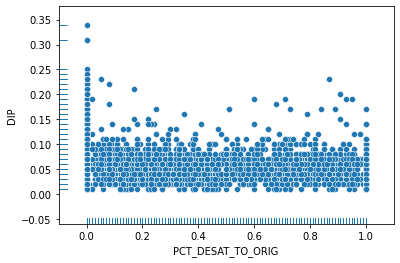

In [207]:
%matplotlib inline

sns.scatterplot(data=df, x='PCT_DESAT_TO_ORIG', y='DIP')
sns.rugplot(data=df, x='PCT_DESAT_TO_ORIG', y='DIP')

# New features: normalized TOTAL_INJ, TOTAL_GNTL_INJ, TOTAL_PROD and SGMT_CUM_STM_INJ_[1/2/3], AVG_OIL_SAT
idea: normalzie this features(total_inj by facility and total_gntl_inj by sand+facility) by maximum value

<AxesSubplot:>

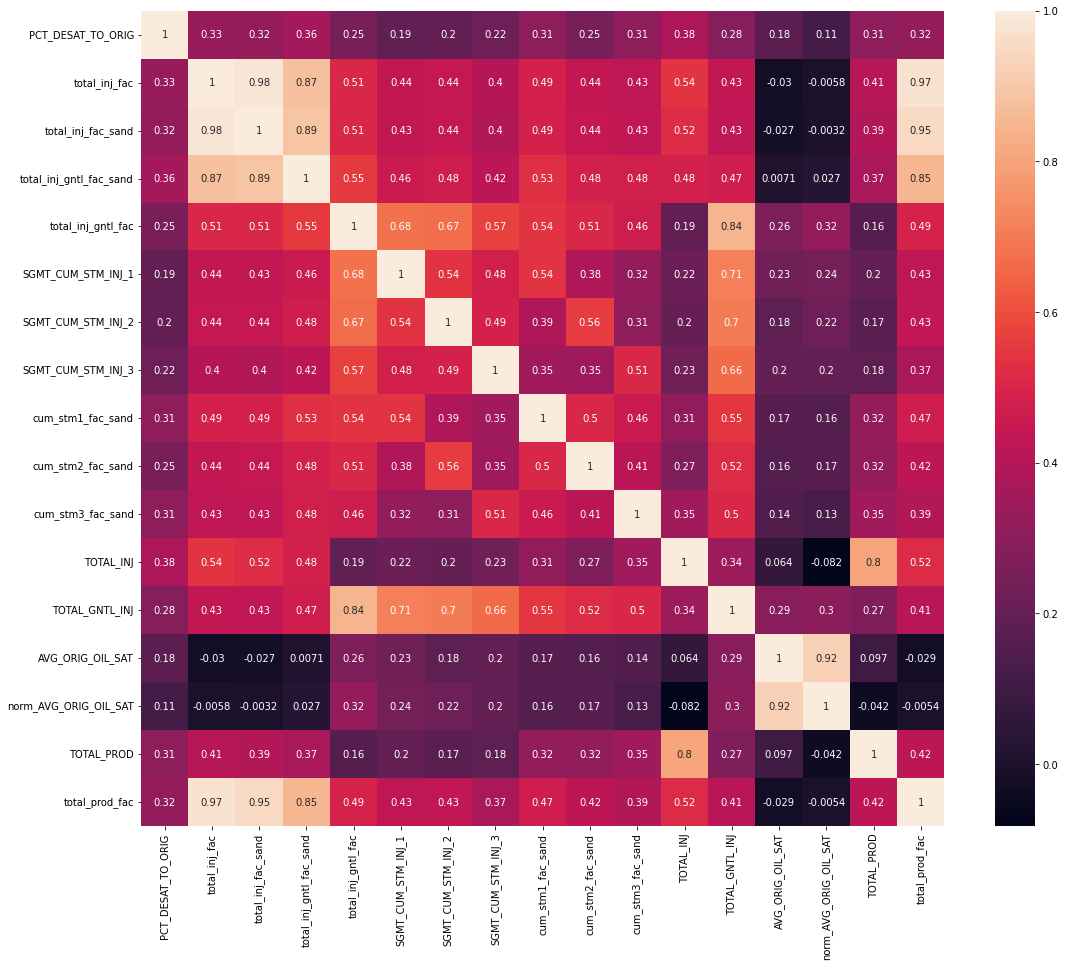

In [95]:
%matplotlib inline

new_df = get_norm_feature_by_group(df_train, group=['CMPL_FAC_ID'], feature='TOTAL_PROD', res_feature_name='total_prod_fac')
new_df = get_norm_feature_by_group(df_train, group=['CMPL_FAC_ID'], feature='TOTAL_INJ', res_feature_name='total_inj_fac')
new_df = get_norm_feature_by_group(df_train, group=['CMPL_FAC_ID', 'SAND'], feature='TOTAL_INJ', res_feature_name='total_inj_fac_sand')
new_df = get_norm_feature_by_group(new_df, group=['CMPL_FAC_ID', 'SAND'], feature='TOTAL_GNTL_INJ', res_feature_name='total_inj_gntl_fac_sand')
new_df = get_norm_feature_by_group(new_df, group=['CMPL_FAC_ID'], feature='TOTAL_GNTL_INJ', res_feature_name='total_inj_gntl_fac')
new_df = get_norm_feature_by_group(new_df, group=['CMPL_FAC_ID', 'SAND'], feature='SGMT_CUM_STM_INJ_1', res_feature_name='cum_stm1_fac_sand', fillna=0)
new_df = get_norm_feature_by_group(new_df, group=['CMPL_FAC_ID', 'SAND'], feature='SGMT_CUM_STM_INJ_2', res_feature_name='cum_stm2_fac_sand', fillna=0)
new_df = get_norm_feature_by_group(new_df, group=['CMPL_FAC_ID', 'SAND'], feature='SGMT_CUM_STM_INJ_3', res_feature_name='cum_stm3_fac_sand', fillna=0)
new_df = get_norm_feature_by_group(new_df, group=['CMPL_FAC_ID'], feature='AVG_ORIG_OIL_SAT', res_feature_name='norm_AVG_ORIG_OIL_SAT', fillna=0)

needest_features = [
       'PCT_DESAT_TO_ORIG', 'total_inj_fac', 'total_inj_fac_sand', 'total_inj_gntl_fac_sand', 'total_inj_gntl_fac',
       'SGMT_CUM_STM_INJ_1', 'SGMT_CUM_STM_INJ_2', 'SGMT_CUM_STM_INJ_3',
       'cum_stm1_fac_sand', 'cum_stm2_fac_sand', 'cum_stm3_fac_sand',
       'TOTAL_INJ', 'TOTAL_GNTL_INJ', 'AVG_ORIG_OIL_SAT', 'norm_AVG_ORIG_OIL_SAT',
       'TOTAL_PROD', 'total_prod_fac'
]

_, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(new_df[needest_features].corr(), annot=True, ax=ax)

# Feature of changing total_prod, total_inj(gntl)

In [72]:
def get_feature_change_by_time(df, feature, new_feature_name, normalize=False):
    indexes, values = [], []
    for mini_df in df.sort_values(by='SURV_DTE').groupby(by=['CMPL_FAC_ID', 'SAND']):
        mini_df = mini_df[1].reset_index()
        changes = mini_df[feature].diff()
        
        if normalize:
            changes = changes / mini_df[feature].shift(periods=1)
            changes = changes.replace(np.inf, 1.0)
            
        changes = changes.fillna(0)  
        
        indexes += mini_df['index'].tolist()
        values += changes.tolist()
        
    df.loc[indexes, new_feature_name] = values
    return df

In [76]:
new_df = df_train.copy()
new_df['SURV_DTE'] = new_df['SURV_DTE'].map(get_surv_dte)

new_df = get_feature_change_by_time(new_df, feature='TOTAL_INJ', new_feature_name='total_inj_change')
new_df = get_feature_change_by_time(new_df, feature='TOTAL_GNTL_INJ', new_feature_name='total_gntl_inj_change')
new_df = get_feature_change_by_time(new_df, feature='TOTAL_PROD', new_feature_name='total_prod_change')
new_df = get_feature_change_by_time(new_df, feature='TOTAL_INJ', new_feature_name='total_inj_change_p', normalize=True)
new_df = get_feature_change_by_time(new_df, feature='TOTAL_GNTL_INJ', new_feature_name='total_gntl_inj_change_p', normalize=True)
new_df = get_feature_change_by_time(new_df, feature='TOTAL_PROD', new_feature_name='total_prod_change_p', normalize=True)

# add sand group number
grn = new_df['SAND'].map(sand_group_num_encoding).to_numpy()
new_df['SAND_group'] = [_[0] for _ in grn]
df_gr_dum = pd.get_dummies(new_df['SAND_group'], prefix='SAND_group')
new_df = pd.concat([new_df, df_gr_dum], axis=1)

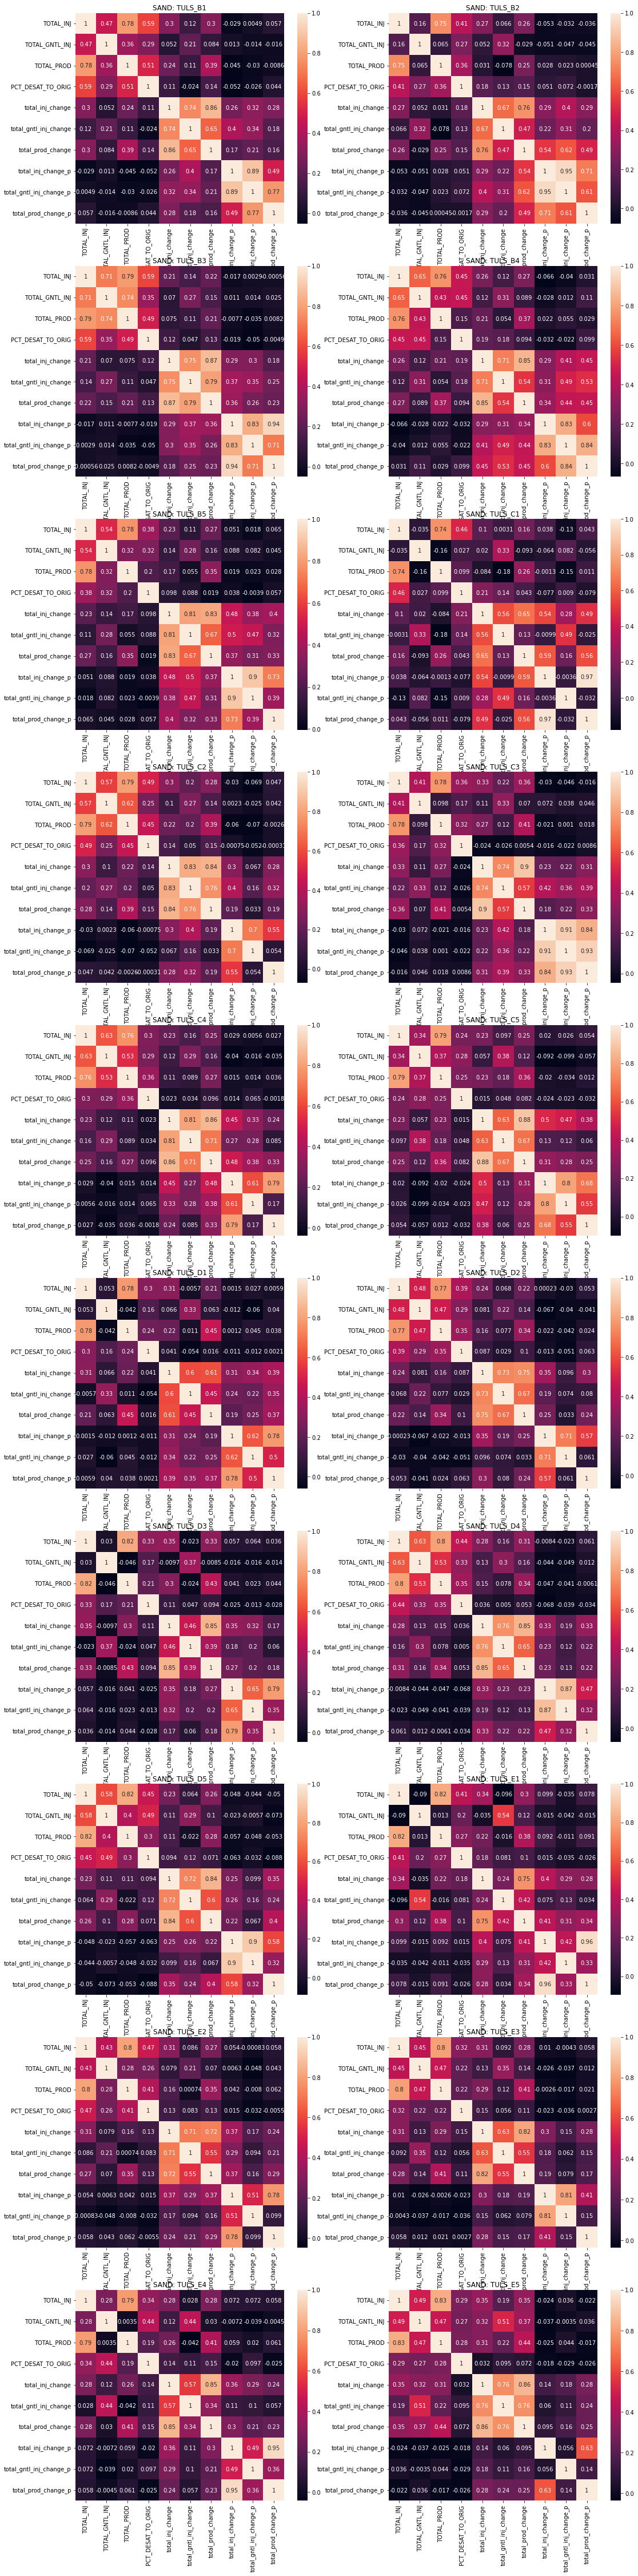

In [91]:
%matplotlib inline

cols = [
       'TOTAL_INJ', 'TOTAL_GNTL_INJ', 'TOTAL_PROD', 'PCT_DESAT_TO_ORIG',
       'total_inj_change', 'total_gntl_inj_change', 'total_prod_change',
       'total_inj_change_p', 'total_gntl_inj_change_p', 'total_prod_change_p'
]

_, ax = plt.subplots(figsize=(18, 8*10), nrows=10, ncols=2)
ax = ax.flatten()

# for i in range(4):
    
#     sns.heatmap(new_df[new_df[f'SAND_group_{i+1}'] == 1][cols].corr(), annot=True, ax=ax[i])
#     ax[i].set_title(f'Group: {i+1}')

for i, sand_id in enumerate(np.sort(new_df['SAND'].unique())):
    sns.heatmap(new_df[new_df['SAND'] == sand_id][cols].corr(), annot=True, ax=ax[i])
    ax[i].set_title(f'SAND: {sand_id}')

# Traget distribution analysis

## Split target by bins

In [33]:
RANDOM_STATE = 42

PROJ_PATH = "/home/kirill/projects/personal_projects/xeek-Steam-Optimization/"
train_data_path = PROJ_PATH + "data/raw/train.csv"
test_data_path = PROJ_PATH + "data/raw/test_data.csv"

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

In [13]:
def get_target_group(t):
    if t == 0:
        return 1
    if 0 < t < 1:
        return 2
    else:
        return 3
    
new_df = df_train.copy()

new_df['t_group'] = new_df['PCT_DESAT_TO_ORIG'].map(get_target_group)

new_df['sands_num'] = new_df['CMPL_FAC_ID'].map(get_sand_num_mapping(new_df))
new_df['SURV_DTE'] = new_df['SURV_DTE'].map(get_surv_dte)
new_df['steam_inj_nums'] = new_df.apply(get_sinjectors_num, axis=1)

new_df = get_seq_num(new_df, normalize=True)
new_df = get_seq_num(new_df, res_feature_name='seq_num_un', normalize=False)
new_df = get_life_time(new_df, group=['CMPL_FAC_ID', 'SAND'], res_feature_name='fcl_sand_life_time', normalize=True)
new_df = get_life_time(new_df, normalize=True)

<AxesSubplot:xlabel='PCT_DESAT_TO_ORIG', ylabel='Count'>

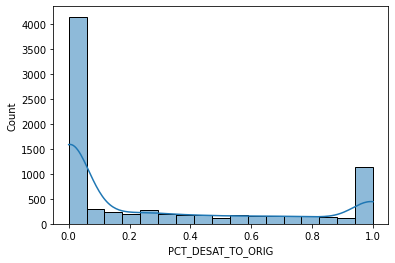

In [20]:
%matplotlib inline

sns.histplot(new_df['PCT_DESAT_TO_ORIG'], kde=True)

<AxesSubplot:xlabel='t_group', ylabel='Count'>

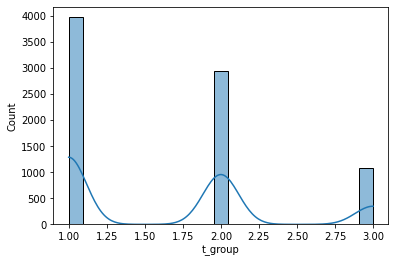

In [21]:
%matplotlib inline

sns.histplot(new_df['t_group'], kde=True)

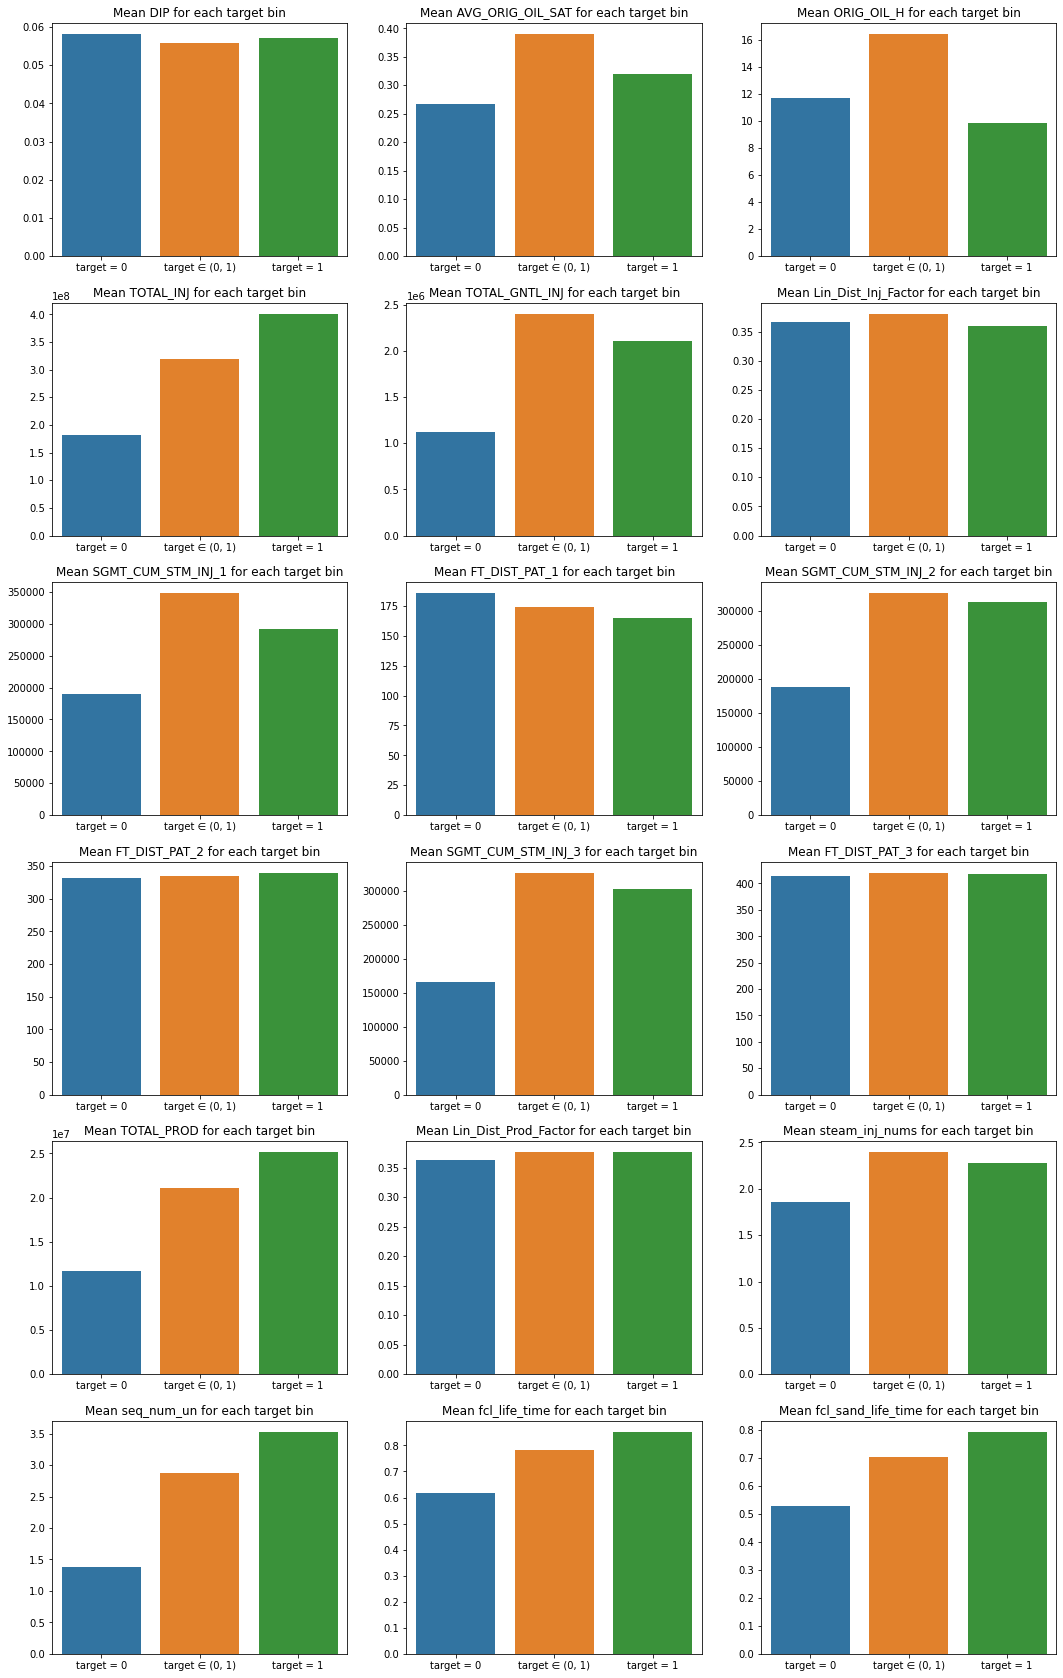

In [15]:
%matplotlib inline
# show mean of features for each group

needest_columns = [
    'DIP', 'AVG_ORIG_OIL_SAT', 'ORIG_OIL_H', 'TOTAL_INJ', 'TOTAL_GNTL_INJ',
    'Lin_Dist_Inj_Factor', 'SGMT_CUM_STM_INJ_1', 'FT_DIST_PAT_1', 'SGMT_CUM_STM_INJ_2',
    'FT_DIST_PAT_2', 'SGMT_CUM_STM_INJ_3', 'FT_DIST_PAT_3', 'TOTAL_PROD', 'Lin_Dist_Prod_Factor',
    'steam_inj_nums', 'seq_num_un', 'fcl_life_time', 'fcl_sand_life_time'
]

_, ax = plt.subplots(figsize=(18, 30), ncols=3, nrows=6)
ax = ax.flatten()

for i, f in enumerate(needest_columns):
    info = new_df.groupby(by='t_group')[f].mean()
    info.index = ['target = 0', 'target ∈ (0, 1)', 'target = 1']
    
    sns.barplot(x=info.index, y=info.values, ax=ax[i])
    ax[i].set_title(f'Mean {f} for each target bin')
    
    #print()

## Clustering target
New features: distantions to n centroids. 
I will use the same features as in the best solution

In [98]:
# prepare data

RANDOM_STATE = 42

PROJ_PATH = "/home/kirill/projects/personal_projects/xeek-Steam-Optimization/"
train_data_path = PROJ_PATH + "data/raw/train.csv"
test_data_path = PROJ_PATH + "data/raw/test_data.csv"

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

norm = Normalizer()
new_df = df_train.copy()

new_df['sands_num'] = new_df['CMPL_FAC_ID'].map(get_sand_num_mapping(new_df))
new_df['SURV_DTE'] = new_df['SURV_DTE'].map(get_surv_dte)
new_df['steam_inj_nums'] = new_df.apply(get_sinjectors_num, axis=1)

new_df = get_seq_num(new_df, normalize=True)
new_df = get_seq_num(new_df, res_feature_name='seq_num_un', normalize=True)
new_df = get_life_time(new_df, group=['CMPL_FAC_ID', 'SAND'], res_feature_name='fcl_sand_life_time', normalize=True)
new_df = get_life_time(new_df, normalize=True)
new_df = move_sinjectors_columns(new_df)
df_sand_ohe = pd.get_dummies(data=new_df['SAND'], prefix='SAND')
new_df = pd.concat([new_df, df_sand_ohe], axis=1)


needest_columns = [
    'DIP', 'AVG_ORIG_OIL_SAT', 'ORIG_OIL_H', 'TOTAL_INJ', 'TOTAL_GNTL_INJ',
    'Lin_Dist_Inj_Factor', 'SGMT_CUM_STM_INJ_1', 'FT_DIST_PAT_1', 'SGMT_CUM_STM_INJ_2',
    'FT_DIST_PAT_2', 'SGMT_CUM_STM_INJ_3', 'FT_DIST_PAT_3', 'TOTAL_PROD', 'Lin_Dist_Prod_Factor'
]
needest_sand_columns = [c for c in new_df.columns if 'SAND_' in c]
needest_columns = needest_columns + needest_sand_columns + ['steam_inj_nums'] +\
                      ['seq_num_un', 'fcl_life_time', 'fcl_sand_life_time']

X, y = new_df[needest_columns].fillna(-1), new_df['PCT_DESAT_TO_ORIG'].to_numpy()
X = X.to_numpy()
X_norm = norm.fit_transform(X)

8004it [00:16, 499.29it/s]


/home/kirill/projects/personal_projects/xeek-Steam-Optimization/venv/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/kirill/projects/personal_projects/xeek-Steam-Optimization/venv/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


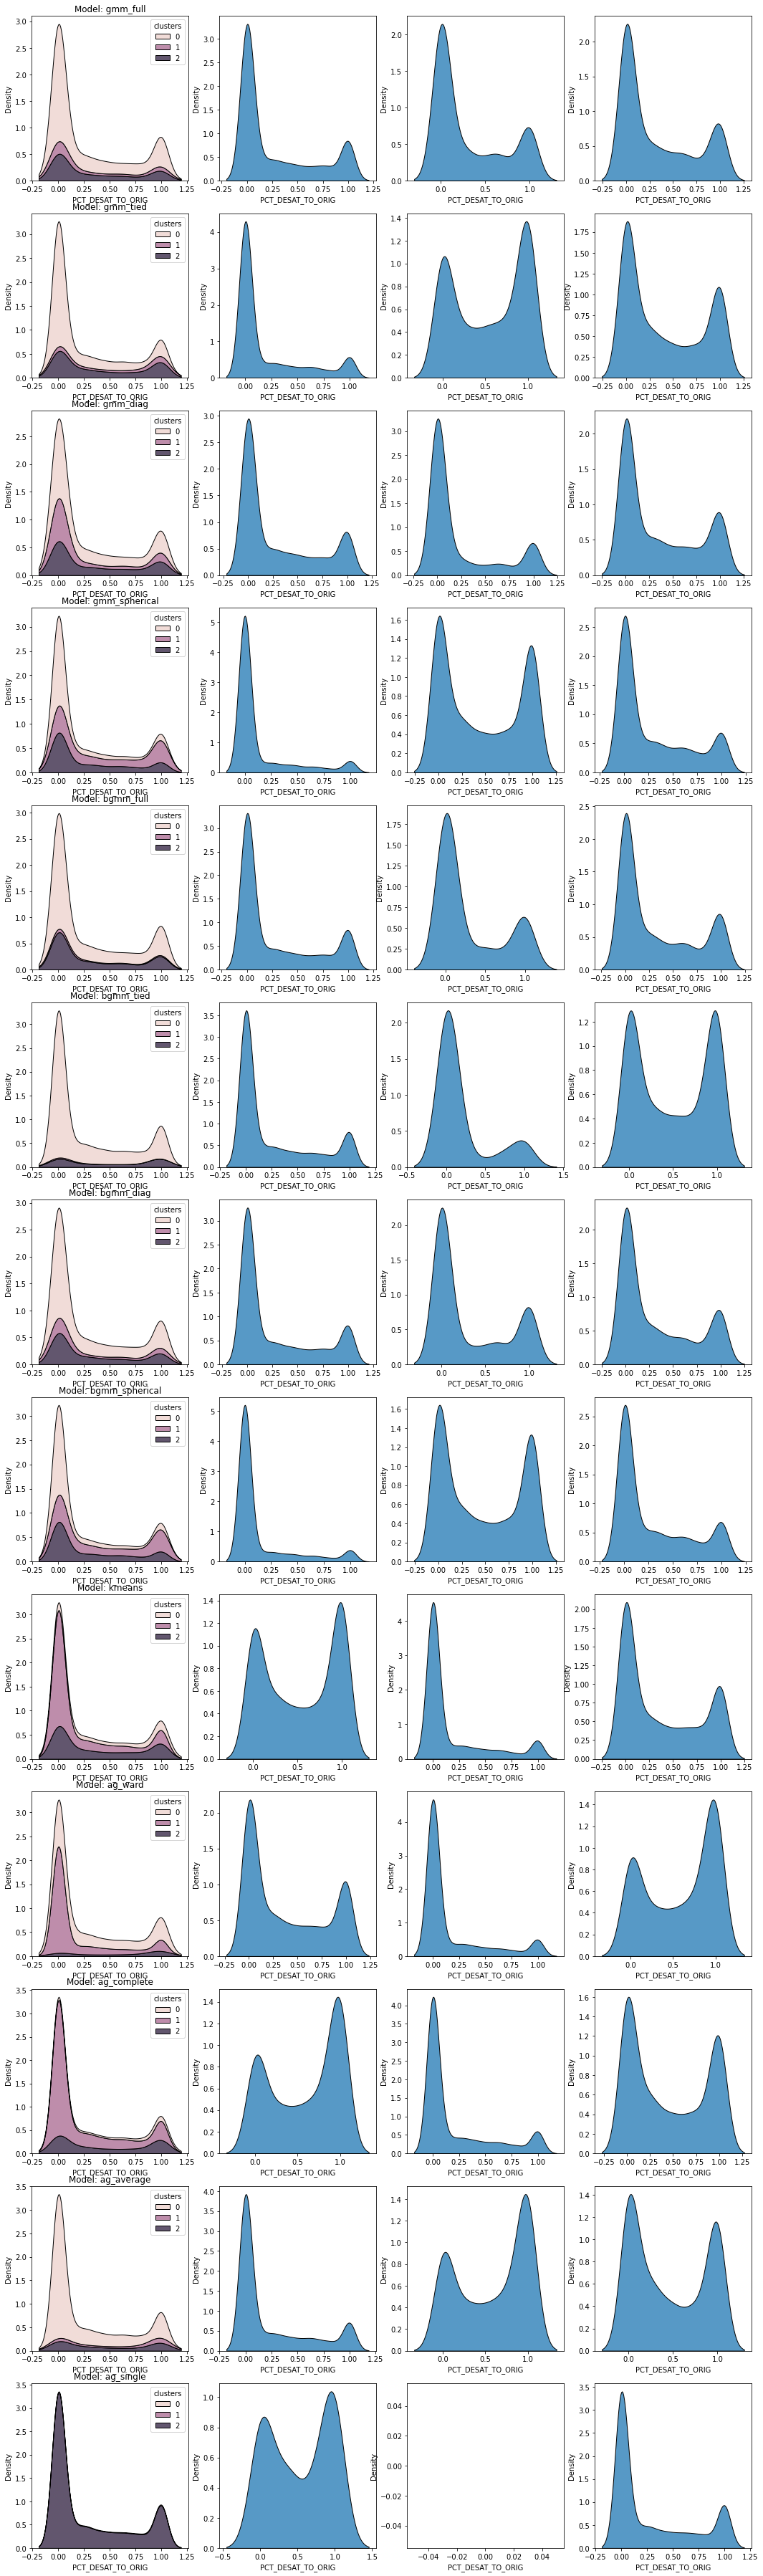

In [102]:
%matplotlib inline

n_cl = 3
cluster_2c_models ={
    'gmm_full': GaussianMixture(n_components=n_cl, random_state=42, covariance_type='full'),
    'gmm_tied': GaussianMixture(n_components=n_cl, random_state=42, covariance_type='tied'),
    'gmm_diag': GaussianMixture(n_components=n_cl, random_state=42, covariance_type='diag'),
    'gmm_spherical': GaussianMixture(n_components=n_cl, random_state=42, covariance_type='spherical'),
    
    'bgmm_full': BayesianGaussianMixture(n_components=n_cl, random_state=42, covariance_type='full'),
    'bgmm_tied': BayesianGaussianMixture(n_components=n_cl, random_state=42, covariance_type='tied'),
    'bgmm_diag': BayesianGaussianMixture(n_components=n_cl, random_state=42, covariance_type='diag'),
    'bgmm_spherical': BayesianGaussianMixture(n_components=n_cl, random_state=42, covariance_type='spherical'),
    
    'kmeans': KMeans(n_clusters=n_cl, random_state=42),
    
    'ag_ward': AgglomerativeClustering(n_clusters=n_cl, linkage='ward'),
    'ag_complete': AgglomerativeClustering(n_clusters=n_cl, linkage='complete'),
    'ag_average': AgglomerativeClustering(n_clusters=n_cl, linkage='average'),
    'ag_single': AgglomerativeClustering(n_clusters=n_cl, linkage='single')
    
    
}

models_len = len(cluster_2c_models.keys())
_, ax = plt.subplots(figsize=(18, 5*models_len), ncols=4, nrows=models_len)
ax = ax.flatten()

for i, (n, model) in enumerate(cluster_2c_models.items()):
    model.fit(X)
    
    if hasattr(model, 'predict'):
        clusters = model.predict(X)
    else:
        clusters = model.labels_     
    new_df['clusters'] = clusters
    
    ax[4*i].set_title(f'Model: {n}')
    sns.kdeplot(data=new_df, x='PCT_DESAT_TO_ORIG', hue='clusters', multiple="stack", ax=ax[4*i])
    sns.kdeplot(data=new_df[new_df['clusters'] == 0], x='PCT_DESAT_TO_ORIG', multiple="stack", ax=ax[4*i + 1])
    sns.kdeplot(data=new_df[new_df['clusters'] == 1], x='PCT_DESAT_TO_ORIG', multiple="stack", ax=ax[4*i + 2])
    sns.kdeplot(data=new_df[new_df['clusters'] == 2], x='PCT_DESAT_TO_ORIG', multiple="stack", ax=ax[4*i + 3])

# New feature: Time(towards to 1990)

In [173]:
def get_norm_days_time(date, min_date='1990.01.01', max_date='2022.01.01'):
    min_date, max_date = pd.to_datetime(min_date), pd.to_datetime(max_date)
    max_days = (max_date - min_date).days
    
    d = pd.to_datetime(date)
    
    return (d - min_date).days / max_days

In [174]:
get_norm_days_time('1994-09-27')

0.14801505817932922

In [21]:
testing_data_path = PROJ_PATH + "data/processed/testing.csv"
df_tst = pd.read_csv(testing_data_path)

df_tst = df_tst[['CMPL_FAC_ID', 'SAND', 'SURV_DTE', 'AVG_ORIG_OIL_SAT', 'TOTAL_INJ', 'TOTAL_GNTL_INJ', 
          'TOTAL_PROD', 'PCT_DESAT_TO_ORIG', 'predicted_targ', 'total_inj_fac', 'total_inj_fac_sand', 'seq_num_un', 'fcl_life_time', 
                'fcl_sand_life_time']]

In [25]:
df_tst.iloc[530:560]

CMPL_FAC_ID     SAND    SURV_DTE   DIP  AVG_ORIG_OIL_SAT  ORIG_OIL_H  \
530       142217  TULS_D1  1994-09-27  0.07              0.39       13.50   
531       142217  TULS_D1  1997-04-01  0.07              0.39       13.50   
532       142217  TULS_D1  2000-01-13  0.07              0.39       13.50   
533       142217  TULS_D1  2005-01-01  0.07              0.39       13.50   
534       142217  TULS_D1  2003-01-01  0.07              0.39       13.50   
535       142217  TULS_D2  1994-09-27  0.07              0.68       16.20   
536       142217  TULS_D2  1997-04-01  0.07              0.68       16.20   
537       142217  TULS_D2  2000-01-13  0.07              0.68       16.20   
538       142217  TULS_D2  2003-01-01  0.07              0.68       16.20   
539       142217  TULS_D2  2005-01-01  0.07              0.68       16.20   
540       142217  TULS_C4  1994-09-27  0.04              0.09        4.50   
541       142217  TULS_C4  1997-04-01  0.04              0.09        4.50   
542       142217  TULS_C4  2000-01-13  0.04              0.09        4.50   
543       142217  TULS_C4  2003-01-01  0.04              0.09        4.50   
544       142217  TULS_C4  2005-01-01  0.04              0.09        4.50   
545       142217  TULS_D3  1994-09-27  0.08              0.25        5.30   
546       142217  TULS_D3  1997-04-01  0.08              0.25        5.30   
547       142217  TULS_D3  2000-01-13  0.08              0.25        5.30   
548       142217  TULS_D3  2003-01-01  0.08              0.25        5.30   
549       142217  TULS_D3  2005-01-01  0.08              0.25        5.30   
550       142217  TULS_D4  1990-01-01  0.09              0.50       12.34   
551       142217  TULS_D4  1994-09-27  0.09              0.50       12.34   
552       142217  TULS_D4  1997-04-01  0.09              0.50       12.34   
553       142217  TULS_D4  2000-01-13  0.09              0.50       12.34   
554       142217  TULS_D4  2003-01-01  0.09              0.50       12.34   
555       142217  TULS_D4  2005-01-01  0.09              0.50       12.34   
556       142217  TULS_E2  1994-09-27  0.06              0.23        8.00   
557       142217  TULS_E2  1997-04-01  0.06              0.23        8.00   
558       142217  TULS_E2  2000-01-13  0.06              0.23        8.00   
559       142217  TULS_E2  2003-01-01  0.06              0.23        8.00   

        TOTAL_INJ  TOTAL_GNTL_INJ  Lin_Dist_Inj_Factor  TOTAL_PROD  \
530  4.705549e+07           12332                0.450     6741555   
531  2.196420e+08          328549                0.450    21811875   
532  3.714739e+08          396317                0.450    31695373   
533  4.840915e+08          396317                0.450    46161203   
534  4.469916e+08          396317                0.450    40132110   
535  4.705549e+07          279253                0.326     6741555   
536  2.196420e+08          975531                0.304    21811875   
537  3.714739e+08         1562492                0.322    31695373   
538  4.469916e+08         2109439                0.316    40132110   
539  4.840915e+08         2218363                0.318    46161203   
540  4.705549e+07          479365                0.402     6741555   
541  2.196420e+08         1878542                0.370    21811875   
542  3.714739e+08         2942491                0.350    31695373   
543  4.469916e+08         3570902                0.338    40132110   
544  4.840915e+08         3950488                0.329    46161203   
545  4.705549e+07          194453                0.304     6741555   
546  2.196420e+08          973494                0.320    21811875   
547  3.714739e+08         1593713                0.308    31695373   
548  4.469916e+08         1833074                0.302    40132110   
549  4.840915e+08         1994834                0.298    46161203   
550  0.000000e+00               0                0.769           0   
551  4.705549e+07           36444                0.769     6741555   
552  2.

In [10]:
a = df_tst[df_tst['CMPL_FAC_ID'] == 142217]
a = a.sort_values(by=['SURV_DTE'])
a

CMPL_FAC_ID     SAND    SURV_DTE   DIP  AVG_ORIG_OIL_SAT  ORIG_OIL_H  \
550       142217  TULS_D4  1990-01-01  0.09              0.50       12.34   
506       142217  TULS_C5  1994-09-27  0.07              0.30        7.00   
535       142217  TULS_D2  1994-09-27  0.07              0.68       16.20   
545       142217  TULS_D3  1994-09-27  0.08              0.25        5.30   
530       142217  TULS_D1  1994-09-27  0.07              0.39       13.50   
525       142217  TULS_C2  1994-09-27  0.05              0.48       10.20   
551       142217  TULS_D4  1994-09-27  0.09              0.50       12.34   
520       142217  TULS_B3  1994-09-27  0.05              0.67       21.40   
556       142217  TULS_E2  1994-09-27  0.06              0.23        8.00   
540       142217  TULS_C4  1994-09-27  0.04              0.09        4.50   
560       142217  TULS_E4  1994-09-27  0.07              0.12        4.50   
565       142217  TULS_E5  1994-09-27  0.07              0.24        7.50   
510       142217  TULS_D5  1994-09-27  0.07              0.62       18.16   
515       142217  TULS_B2  1994-09-27  0.05              0.72       22.10   
516       142217  TULS_B2  1997-04-01  0.05              0.72       22.10   
507       142217  TULS_C5  1997-04-01  0.07              0.30        7.00   
541       142217  TULS_C4  1997-04-01  0.04              0.09        4.50   
566       142217  TULS_E5  1997-04-01  0.07              0.24        7.50   
531       142217  TULS_D1  1997-04-01  0.07              0.39       13.50   
546       142217  TULS_D3  1997-04-01  0.08              0.25        5.30   
526       142217  TULS_C2  1997-04-01  0.05              0.48       10.20   
552       142217  TULS_D4  1997-04-01  0.09              0.50       12.34   
536       142217  TULS_D2  1997-04-01  0.07              0.68       16.20   
561       142217  TULS_E4  1997-04-01  0.07              0.12        4.50   
557       142217  TULS_E2  1997-04-01  0.06              0.23        8.00   
511       142217  TULS_D5  1997-04-01  0.07              0.62       18.16   
521       142217  TULS_B3  1997-04-01  0.05              0.67       21.40   
562       142217  TULS_E4  2000-01-13  0.07              0.12        4.50   
547       142217  TULS_D3  2000-01-13  0.08              0.25        5.30   
553       142217  TULS_D4  2000-01-13  0.09              0.50       12.34   
542       142217  TULS_C4  2000-01-13  0.04              0.09        4.50   
558       142217  TULS_E2  2000-01-13  0.06              0.23        8.00   
537       142217  TULS_D2  2000-01-13  0.07              0.68       16.20   
522       142217  TULS_B3  2000-01-13  0.05              0.67       21.40   
532       142217  TULS_D1  2000-01-13  0.07              0.39       13.50   
529       142217  TULS_C3  2000-01-13  0.05              0.13        4.50   
512       142217  TULS_D5  2000-01-13  0.07              0.62       18.16   
517       142217  TULS_B2  2000-01-13  0.05              0.72       22.10   
518       142217  TULS_B2  2003-01-01  0.05              0.72       22.10   
513       142217  TULS_D5  2003-01-01  0.07              0.62       18.16   
554       142217  TULS_D4  2003-01-01  0.09              0.50       12.34   
538       142217  TULS_D2  2003-01-01  0.07              0.68       16.20   
523       142217  TULS_B3  2003-01-01  0.05              0.67       21.40   
527       142217  TULS_C2  2003-01-01  0.05              0.48       10.20   
563       142217  TULS_E4  2003-01-01  0.07              0.12        4.50   
543       142217  TULS_C4  2003-01-01  0.04              0.09        4.50   
508       142217  TULS_C5  2003-01-01  0.07              0.30        7.00   
534       142217  TULS_D1  2003-01-01  0.07              0.39       13.50   
567       142217  TULS_E5  2003-01-01  0.07              0.24        7.50   
548       142217  TULS_D3  2003-01-01  0.08              0.25        5.30   
559       142217  TULS_E2  2003-01-01  0.06              0.23        8.00   
5

In [12]:
a[a['SAND'] == 'TULS_D1']

CMPL_FAC_ID     SAND    SURV_DTE   DIP  AVG_ORIG_OIL_SAT  ORIG_OIL_H  \
530       142217  TULS_D1  1994-09-27  0.07              0.39        13.5   
531       142217  TULS_D1  1997-04-01  0.07              0.39        13.5   
532       142217  TULS_D1  2000-01-13  0.07              0.39        13.5   
534       142217  TULS_D1  2003-01-01  0.07              0.39        13.5   
533       142217  TULS_D1  2005-01-01  0.07              0.39        13.5   

        TOTAL_INJ  TOTAL_GNTL_INJ  Lin_Dist_Inj_Factor  TOTAL_PROD  \
530  4.705549e+07           12332                 0.45     6741555   
531  2.196420e+08          328549                 0.45    21811875   
532  3.714739e+08          396317                 0.45    31695373   
534  4.469916e+08          396317                 0.45    40132110   
533  4.840915e+08          396317                 0.45    46161203   

     Lin_Dist_Prod_Factor  PCT_DESAT_TO_ORIG  predicted_targ  total_inj_fac  \
530              0.356555               0.15        0.084113       0.097204   
531              0.346560               0.70        0.267300       0.453720   
532              0.323125               1.00        0.368733       0.767363   
534              0.314074               1.00        0.369263       0.923362   
533              0.306462               1.00        0.369483       1.000000   

     total_inj_fac_sand  seq_num_un  fcl_life_time  fcl_sand_life_time  
530            0.031117         0.0       0.315751            0.000267  
531            0.829006         1.0       0.483117            0.244599  
532            1.000000         2.0       0.668735            0.515871  
534            1.000000         3.0       0.866581            0.805015  
533            1.000000         4.0       1.000000            1.000000

In [14]:
a[a['SAND'] == 'TULS_C5']

CMPL_FAC_ID     SAND    SURV_DTE   DIP  AVG_ORIG_OIL_SAT  ORIG_OIL_H  \
506       142217  TULS_C5  1994-09-27  0.07               0.3         7.0   
507       142217  TULS_C5  1997-04-01  0.07               0.3         7.0   
508       142217  TULS_C5  2003-01-01  0.07               0.3         7.0   
509       142217  TULS_C5  2005-01-01  0.07               0.3         7.0   

        TOTAL_INJ  TOTAL_GNTL_INJ  Lin_Dist_Inj_Factor  TOTAL_PROD  \
506  4.705549e+07          232688                0.293     6741555   
507  2.196420e+08         1031776                0.336    21811875   
508  4.469916e+08         2407229                0.321    40132110   
509  4.840915e+08         2638609                0.319    46161203   

     Lin_Dist_Prod_Factor  PCT_DESAT_TO_ORIG  predicted_targ  total_inj_fac  \
506              0.356555               0.71        0.089830       0.097204   
507              0.346560               1.00        0.189737       0.453720   
508              0.314074               0.71        0.362647       0.923362   
509              0.306462               0.86        0.352883       1.000000   

     total_inj_fac_sand  seq_num_un  fcl_life_time  fcl_sand_life_time  
506            0.088186         0.0       0.315751            0.000267  
507            0.391030         1.0       0.483117            0.244599  
508            0.912310         2.0       0.866581            0.805015  
509            1.000000         3.0       1.000000            1.000000

In [31]:
df_tst.iloc[2900:]

CMPL_FAC_ID     SAND    SURV_DTE  AVG_ORIG_OIL_SAT     TOTAL_INJ  \
2900       142543  TULS_E2  2006-01-01              0.43  4.523152e+08   
2901       142543  TULS_E2  2007-01-01              0.43  4.598825e+08   
2902       142543  TULS_E2  2009-06-10              0.43  4.667557e+08   
2903       142543  TULS_E3  1990-01-01              0.47  0.000000e+00   
2904       142543  TULS_E3  1993-03-10              0.47  2.972414e+07   
...           ...      ...         ...               ...           ...   
7999      1009291  TULS_D1  2020-03-29              0.21  2.351197e+08   
8000      1009291  TULS_D2  1990-01-01              0.19  0.000000e+00   
8001      1009291  TULS_D2  2020-03-29              0.19  2.351197e+08   
8002      1009291  TULS_D4  2020-03-29              0.21  2.351197e+08   
8003      1009291  TULS_E5  2020-03-29              0.20  2.351197e+08   

      TOTAL_GNTL_INJ  TOTAL_PROD  PCT_DESAT_TO_ORIG  predicted_targ  \
2900         1839520    36874846               1.00        0.558260   
2901         1862947    38231482               1.00        0.571003   
2902         1883279    41452785               1.00        0.571223   
2903               0           0               0.00        0.000820   
2904          169752      508416               0.00        0.032057   
...              ...         ...                ...             ...   
7999         2786043    14844194               0.00        0.667243   
8000               0           0               0.00        0.003563   
8001         2298752    14844194               0.00        0.626480   
8002          263145    14844194               0.84        0.318647   
8003          994188    14844194               0.02        0.241430   

      total_inj_fac  total_inj_fac_sand  seq_num_un  fcl_life_time  \
2900       0.969062            0.976764         6.0       0.823099   
2901       0.985274            0.989204         7.0       0.874507   
2902       1.000000            1.000000         8.0       1.000000   
2903       0.000000            0.000000         0.0       0.000141   
2904       0.063682            0.033343         1.0       0.163944   
...             ...                 ...         ...            ...   
7999       1.000000            1.000000         0.0       1.000000   
8000       0.000000            0.000000         0.0       0.000091   
8001       1.000000            1.000000         1.0       1.000000   
8002       1.000000            1.000000         0.0       1.000000   
8003       1.000000            1.000000         0.0       1.000000   

      fcl_sand_life_time  
2900            0.788410  
2901            0.849899  
2902            1.000000  
2903            0.000161  
2904            0.187470  
...                  ...  
7999            1.000000  
8000            0.000091  
8001            1.000000  
8002            1.000000  
8003            1.000000  

[5104 rows x 14 columns]

In [94]:
a = df_tst[df_tst['CMPL_FAC_ID'] == 142549]
a = a.sort_values(by=['SURV_DTE'])
a

CMPL_FAC_ID     SAND    SURV_DTE  AVG_ORIG_OIL_SAT     TOTAL_INJ  \
2942       142549  TULS_B1  1990-01-01              0.68  0.000000e+00   
2954       142549  TULS_B2  1993-05-21              0.35  4.718090e+06   
2943       142549  TULS_B1  1993-05-21              0.68  4.718090e+06   
2964       142549  TULS_B4  1993-05-21              0.53  4.718090e+06   
2975       142549  TULS_B3  1993-05-21              0.15  4.718090e+06   
2955       142549  TULS_B2  1997-08-28              0.35  9.748578e+07   
2965       142549  TULS_B4  1997-08-28              0.53  9.748578e+07   
2976       142549  TULS_B3  1997-08-28              0.15  9.748578e+07   
3033       142549  TULS_E5  1997-08-28              0.65  9.748578e+07   
2944       142549  TULS_B1  1997-08-28              0.68  9.748578e+07   
2922       142549  TULS_B5  1997-08-28              0.18  9.748578e+07   
2996       142549  TULS_D2  1997-08-28              0.64  9.748578e+07   
3006       142549  TULS_D4  1997-08-28              0.44  9.748578e+07   
3016       142549  TULS_E3  1997-08-28              0.43  9.748578e+07   
3025       142549  TULS_E4  1997-08-28              0.04  9.748578e+07   
2932       142549  TULS_D5  1997-08-28              0.45  9.748578e+07   
2986       142549  TULS_C2  1997-08-28              0.34  9.748578e+07   
2987       142549  TULS_C2  2001-01-01              0.34  2.194158e+08   
2977       142549  TULS_B3  2001-01-01              0.15  2.194158e+08   
2997       142549  TULS_D2  2001-01-01              0.64  2.194158e+08   
2966       142549  TULS_B4  2001-01-01              0.53  2.194158e+08   
3007       142549  TULS_D4  2001-01-01              0.44  2.194158e+08   
3017       142549  TULS_E3  2001-01-01              0.43  2.194158e+08   
3027       142549  TULS_E4  2001-01-01              0.04  2.194158e+08   
3034       142549  TULS_E5  2001-01-01              0.65  2.194158e+08   
2923       142549  TULS_B5  2001-01-01              0.18  2.194158e+08   
2945       142549  TULS_B1  2001-01-01              0.68  2.194158e+08   
2933       142549  TULS_D5  2001-01-01              0.45  2.194158e+08   
2978       142549  TULS_B3  2004-01-01              0.15  3.072085e+08   
2924       142549  TULS_B5  2004-01-01              0.18  3.072085e+08   
2934       142549  TULS_D5  2004-01-01              0.45  3.072085e+08   
3023       142549  TULS_E4  2004-01-01              0.04  3.072085e+08   
3018       142549  TULS_E3  2004-01-01              0.43  3.072085e+08   
2956       142549  TULS_B2  2004-01-01              0.35  3.072085e+08   
2967       142549  TULS_B4  2004-01-01              0.53  3.072085e+08   
3008       142549  TULS_D4  2004-01-01              0.44  3.072085e+08   
2988       142549  TULS_C2  2004-01-01              0.34  3.072085e+08   
2998       142549  TULS_D2  2004-01-01              0.64  3.072085e+08   
2946       142549  TULS_B1  2004-01-01              0.68  3.072085e+08   
2979       142549  TULS_B3  2005-01-01              0.15  3.319016e+08   
3009       142549  TULS_D4  2005-01-01              0.44  3.319016e+08   
2999       142549  TULS_D2  2005-01-01              0.64  3.319016e+08   
2925       142549  TULS_B5  2005-01-01              0.18  3.319016e+08   
3019       142549  TULS_E3  2005-01-01              0.43  3.319016e+08   
3024       142549  TULS_E4  2005-01-01              0.04  3.319016e+08   
2989       142549  TULS_C2  2005-01-01              0.34  3.319016e+08   
2935       142549  TULS_D5  2005-01-01              0.45  3.319016e+08   
2947       142549  TULS_B1  2005-01-01              0.68  3.319016e+08   
2957       142549  TULS_B2  2005-01-01              0.35  3.319016e+08   
2968       142549  TULS_B4  2005-01-01              0.53  3.319016e+08   
2990       142549  TULS_C2  2006-01-01              0.34  3.541279e+08   
3000       142549  TULS_D2  2006-01-01              0.64  3.541279e+08   
2969       142549  TULS_B4  2006-01-01              0.53  3.541279e+08   
2958      

In [93]:
df_tst.iloc[3005:]

CMPL_FAC_ID     SAND    SURV_DTE  AVG_ORIG_OIL_SAT     TOTAL_INJ  \
3005       142549  TULS_D2  2012-12-17              0.64  4.508418e+08   
3006       142549  TULS_D4  1997-08-28              0.44  9.748578e+07   
3007       142549  TULS_D4  2001-01-01              0.44  2.194158e+08   
3008       142549  TULS_D4  2004-01-01              0.44  3.072085e+08   
3009       142549  TULS_D4  2005-01-01              0.44  3.319016e+08   
...           ...      ...         ...               ...           ...   
7999      1009291  TULS_D1  2020-03-29              0.21  2.351197e+08   
8000      1009291  TULS_D2  1990-01-01              0.19  0.000000e+00   
8001      1009291  TULS_D2  2020-03-29              0.19  2.351197e+08   
8002      1009291  TULS_D4  2020-03-29              0.21  2.351197e+08   
8003      1009291  TULS_E5  2020-03-29              0.20  2.351197e+08   

      TOTAL_GNTL_INJ  TOTAL_PROD  PCT_DESAT_TO_ORIG  predicted_targ  \
3005         2200631    50899149               1.00        0.594383   
3006          591327    23697457               0.00        0.152587   
3007         1374186    33981606               0.27        0.333163   
3008         1829099    40338988               0.31        0.437493   
3009         1907607    42178317               0.62        0.465227   
...              ...         ...                ...             ...   
7999         2786043    14844194               0.00        0.667243   
8000               0           0               0.00        0.003563   
8001         2298752    14844194               0.00        0.626480   
8002          263145    14844194               0.84        0.318647   
8003          994188    14844194               0.02        0.241430   

      total_inj_fac  total_inj_fac_sand  seq_num_un  fcl_life_time  \
3005       1.000000            1.000000         9.0       1.000000   
3006       0.216231            0.257847         0.0       0.333413   
3007       0.486680            0.599211         1.0       0.479132   
3008       0.681411            0.797575         2.0       0.609707   
3009       0.736182            0.831808         3.0       0.653351   
...             ...                 ...         ...            ...   
7999       1.000000            1.000000         0.0       1.000000   
8000       0.000000            0.000000         0.0       0.000091   
8001       1.000000            1.000000         1.0       1.000000   
8002       1.000000            1.000000         0.0       1.000000   
8003       1.000000            1.000000         0.0       1.000000   

      fcl_sand_life_time  
3005            1.000000  
3006            0.000179  
3007            0.218605  
3008            0.414490  
3009            0.479964  
...                  ...  
7999            1.000000  
8000            0.000091  
8001            1.000000  
8002            1.000000  
8003            1.000000  

[4999 rows x 14 columns]

In [35]:
df_tst = df_tst.sort_values(by='aboba')

<AxesSubplot:xlabel='aboba', ylabel='PCT_DESAT_TO_ORIG'>

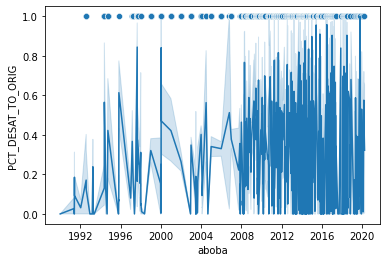

In [67]:
%matplotlib inline

ones_df = df_tst[df_tst['PCT_DESAT_TO_ORIG'] == 1]
sns.lineplot(x=df_tst['aboba'], y=df_tst['PCT_DESAT_TO_ORIG'])
sns.scatterplot(x=ones_df['aboba'], y=ones_df['PCT_DESAT_TO_ORIG'])

In [61]:


df_gr = df_tst.groupby(by='aboba')['PCT_DESAT_TO_ORIG'].mean()

#df_gr['aboba'] = df_gr.index.tolist()
#df_gr['aboba'] = pd.to_datetime(df_gr['aboba'])
#df_gr = df_gr.sort_values(by='aboba')


In [79]:
df_tst['year'] = df_tst['aboba'].map(get_year)

<AxesSubplot:ylabel='Count'>

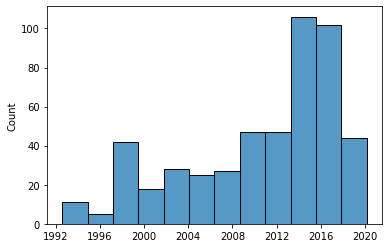

In [95]:
ones_df

ones_df = df_tst[df_tst['PCT_DESAT_TO_ORIG'] == 1]
dates = ones_df.groupby(by=['CMPL_FAC_ID', 'SAND'])['SURV_DTE'].first().tolist()
dates = [pd.to_datetime(i) for i in dates]
sns.histplot(dates)

<AxesSubplot:ylabel='Count'>

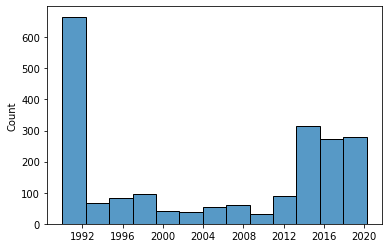

In [96]:
ones_df = df_tst[df_tst['PCT_DESAT_TO_ORIG'] == 0]
dates = ones_df.groupby(by=['CMPL_FAC_ID', 'SAND'])['SURV_DTE'].first().tolist()
dates = [pd.to_datetime(i) for i in dates]
sns.histplot(dates)

In [ ]:
df_tst.group

<AxesSubplot:ylabel='Density'>

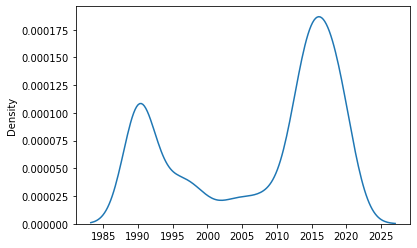

In [94]:
ones_df = df_tst.copy()
dates = ones_df.groupby(by=['CMPL_FAC_ID', 'SAND'])['SURV_DTE'].first().tolist()
dates = [pd.to_datetime(i) for i in dates]
sns.kdeplot(dates)

In [71]:
df_tst[df_tst['PCT_DESAT_TO_ORIG'] == 1]['aboba'].mean()

Timestamp('2009-08-17 00:17:23.866171136')

In [72]:
df_tst[df_tst['PCT_DESAT_TO_ORIG'] == 0]['aboba'].mean()

Timestamp('2005-08-17 10:21:07.605633664')